# Problema: Previsão de série temporal 
Projete a demanda para cada produto nas lojas para os próximos 30, 60 e 90 dias!

 
 The first step when initiating the demand forecasting project is to provide the client with meaningful insights. The process includes the following steps:

Reunir os dados disponíveis
Olhar a estrutura dos dados, acurácia e consistência
Rodar testes e pilotos 
Avaliar o resumo estatistico


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

#modelo
import xgboost as xgb
#metricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#tunning de hiperparametros
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df_canais = pd.read_csv("dados/Canais.csv", delimiter=";")
df_lojas = pd.read_csv("dados/Lojas.csv", delimiter=";")
df_prod = pd.read_csv("dados/Produtos.csv", delimiter=";")
df_unidades = pd.read_csv("dados/Unidades Negócios.csv", delimiter=";")
df_vendas = pd.read_csv("dados/Vendas.csv", delimiter=";")

In [3]:
df_canais #por onde a venda foi feita; ex: ecomerce ou loja fisica

,cod_canal,canal
0,F)ZVUM>YP>1!^J;_E\**)(,Ecom
1,E2J/#5JMB3`*6UR<W)@2.0,Ecom
2,"FW2W&JXXC""<A!FB%@.Z%A,",Ecom
3,"G[)3/J:=M8+NL&V<""+`H30",Loja
4,FEV=2GS'15+!S-%8Z(:W0),Ecom
5,"ENFV?._[""*Z*+8<U+6O?*&",Ecom
6,"AP"".H(2\8_>R#=""JN5-'M0",Ecom
7,"F;60JPCJ#,BA,#YL+""KXD&",Ecom
8,"HMN1XG6D%]ES?GL,C15LW)",Ecom


In [4]:
df_lojas 

,id_loja,cod_loja,ano_abertura,regional,distrito,cidade,uf
0,F!25!6;D=./F%2(E)D;]P0,Loja 1,2013,Regional 1,Distrito R1.1,S�o Paulo,SP
1,"F%#+YX,X!FRF<FHD):`=9+",Loja 2,2011,Regional 2,Distrito R2.1,Rio de Janeiro,RJ
2,F)T`P;^+F]5F7YX^S\=+?&,Loja 3,2017,Regional 2,Distrito R2.2,Bras�lia,DF
3,"FO)5JW59TP?&C:?,ZG$$L*",Loja 4,2017,Regional 1,Distrito R1.2,Sorocaba,SP
4,"FO1G""YC0G6I&C(,H&(MT3-",Loja 5,2018,Regional 1,Distrito R1.2,Santos,SP


In [5]:
df_prod

,produto,fornecedor,produto_nome,categoria,sub_categoria
0,K*C+26:7*$6P)3PQ_%U_&+,Fornecedor 1,Produto 1,Categoria 1,Subcategoria C1.1
1,"A],V_4=/EP2<3_]5N?!4!%",Fornecedor 2,Produto 2,Categoria 1,Subcategoria C1.1
2,EL2!F4Q5(;*)$XX7S@SFJ0,Fornecedor 3,Produto 3,Categoria 1,Subcategoria C1.1
3,"EL""=U15GB/W)$<?@:@BE10",Fornecedor 3,Produto 4,Categoria 1,Subcategoria C1.1
4,"AC""""8K\_G,V\'RCNRU-_(-",Fornecedor 4,Produto 5,Categoria 1,Subcategoria C1.1
...,...,...,...,...,...
15255,C5(!_Y(!?`SJV>3!7S*..%,Fornecedor 155,Produto 15180,Categoria 1,Subcategoria C1.1
15256,P+[^*&&O5V)@7]ZH&BH.Y#,Fornecedor 155,Produto 15181,Categoria 1,Subcategoria C1.1
15257,P+#1C'4F(<3@7/.-Z!`]'&,Fornecedor 155,Produto 15182,Categoria 1,Subcategoria C1.1
15258,"D]'SFK,[_9A-@P]RZ,JIP,",Fornecedor 333,Produto 15183,Categoria 3,Subcategoria C3.3


In [6]:
df_unidades

,id_unidade_negocio,unidade_negocio
0,"F3/>CC-'$Y5AV(,>T:)SH-",Servi�os
1,"AP"".H(2\8_>R#=""JN5-'M0",Servi�os
2,"G[)3/J:=M8+NL&V<""+`H30",Produtos


In [7]:
df_vendas

,id_data,id_loja,id_unidade_negocio,id_canal,id_produto,id_cupom,id_cliente,id_endereco_venda,id_tipo_cliente,qtde_venda,valor_venda,valor_imposto,valor_custo
0,2019-09-21,F)T`P;^+F]5F7YX^S\=+?&,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","AR^$EA+5@,Q][""V`\\VQC,","N_N,M-K1I34E(DW*-FHTX.",N$P5WZFC9VKQM(XS1DBJZ*,"H=ZO(L""MR+7D](@#\""/NG)",A-Z4<6#[I<TA\FNKYY]%:+,"0,6","16,2","4,41","5,736"
1,2019-08-06,F!25!6;D=./F%2(E)D;]P0,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",FC^22=\(:F=0J=F6TNPD.&,"OEUPW7V[BY>]:>T;Y3""KM(","P0K'8UWIADS?T""+9:-W@6*",F'^..@O;\5E;#O4(^_'$0+,"N3ZH'W$AE#+&45Z8N8""S*#","0,6","11,994","2,154","3,084"
2,2019-08-08,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",C2O9ATWBXT.B)L-4@Y-FI$,"B7,9,^VTQPPN)M\$G""/I,,",E\^N9TRHKU5ABQ1=?;J./',"E0(*AW^9CG6ACQ2*,&@LL-","N3ZH'W$AE#+&45Z8N8""S*#","0,6","11,172","3,048","3,192"
3,2019-07-28,"FO)5JW59TP?&C:?,ZG$$L*","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","CIJ6#@,X$@9;"",SB)891P$",JT=[J-@0OCG!X.YRK&Q&3!,"K*""!]6VAE;=C*BS-]/@_*%","H:E2P/CNLQ@T$!(,0BJ,G+","N3ZH'W$AE#+&45Z8N8""S*#","0,6","2,394","0,222","0,468"
4,2019-10-26,F!25!6;D=./F%2(E)D;]P0,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","NLPPIQIA=`-_>0I1)P[$5""","E+VB+$M>3GM`:$V#W?V,P*",EO2UJ\6RWGUP-OSON/+Y)%,"A$ER-0#JA]ENP.WRSZ)#""+","N3ZH'W$AE#+&45Z8N8""S*#","1,8","4,482","1,224","1,296"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081400,2019-11-26,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","C+]_@QHN^Z""=13$34#KGF#","DUUZ-0-*N=1SDL-JN#[>R,",GC9:='0DCELH82JYG)CE(!,"OBDILQJOCNA?0*%*,8Q:F0","N3ZH'W$AE#+&45Z8N8""S*#","0,6","64,794","5,994","34,38"
4081401,2019-08-25,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","CK&\:`,K_NP=E*Y<]:\GM%","KK\WXP)(JCG_H'8N$\*#B""",AZ^6'B)X#8HHSQ^9M5PJP*,"D&K,JBR?""-U2O&$.SR<;@$","N3ZH'W$AE#+&45Z8N8""S*#","0,6","53,964","4,986","30,816"
4081402,2019-11-02,F!25!6;D=./F%2(E)D;]P0,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",M90DRT:D\`0DC!C8'J:-M#,"CR:""Y2$*\ZQ:ND49WDPA$+","DS"";/NU6Y#[GLME[D<I/7&","P`4O-RQI48+`O%\OK?YZ(,","N3ZH'W$AE#+&45Z8N8""S*#","0,6","36,114","6,498","18,498"
4081403,2019-10-28,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",C3VP.=?FF8`!%X^4TLZG-0,"MP<Q*-GE8""R^DH?JF$G;W""","C!LPVVC?4RXH?GP_?OL5Q""","I>--[,+0/3X)N`'TLHBG+-","N3ZH'W$AE#+&45Z8N8""S*#","0,6","6,714","1,83","2,406"


## Juntar dataframes em um só, usando chave-primária
Antes de mais nada: quais são as quantidades que terei disponiveis no futuro para fazer uma previsao sobre venda?
* produto
* data (e demais variaveis relacionadas - feature engeneering)
* lag (feature engereering)

Dado isso, utilizaremos *apenas* os dados que estao nos dataframes de vendas e produtos.

In [8]:
df = df_vendas.merge(df_prod, left_on="id_produto", right_on="produto", how="left")

In [9]:
df.groupby(["id_produto"]).size().reset_index()

,id_produto,0
0,A!&M-NL@E_R<\TCI3*6%C(,41
1,A!.W^2UR:&'U<Z)W@]LVW$,38
2,"A!N8)`BNZ\8<\2VB#L"";X'",44
3,A!VBZDK`O#MU<(K7F:-]-),23
4,"A!VJA!QEMBB<\`B^/,KKI%",64
...,...,...
13791,"P`EK(4;;U`+_N(]]Q[F#H""",13
13792,P`ME>PD*9TL'K\I_?8I2Q0,1019
13793,"P`U/Y6W);,?_ND6U*\W$!#",2556
13794,P`U^V+'0$>2_NTP7GZS?3&,913


In [10]:
df

,id_data,id_loja,id_unidade_negocio,id_canal,id_produto,id_cupom,id_cliente,id_endereco_venda,id_tipo_cliente,qtde_venda,valor_venda,valor_imposto,valor_custo,produto,fornecedor,produto_nome,categoria,sub_categoria
0,2019-09-21,F)T`P;^+F]5F7YX^S\=+?&,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","AR^$EA+5@,Q][""V`\\VQC,","N_N,M-K1I34E(DW*-FHTX.",N$P5WZFC9VKQM(XS1DBJZ*,"H=ZO(L""MR+7D](@#\""/NG)",A-Z4<6#[I<TA\FNKYY]%:+,"0,6","16,2","4,41","5,736","AR^$EA+5@,Q][""V`\\VQC,",Fornecedor 156,Produto 11087,Categoria 1,Subcategoria C1.1
1,2019-08-06,F!25!6;D=./F%2(E)D;]P0,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",FC^22=\(:F=0J=F6TNPD.&,"OEUPW7V[BY>]:>T;Y3""KM(","P0K'8UWIADS?T""+9:-W@6*",F'^..@O;\5E;#O4(^_'$0+,"N3ZH'W$AE#+&45Z8N8""S*#","0,6","11,994","2,154","3,084",FC^22=\(:F=0J=F6TNPD.&,Fornecedor 205,Produto 1859,Categoria 5,Subcategoria C5.1
2,2019-08-08,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",C2O9ATWBXT.B)L-4@Y-FI$,"B7,9,^VTQPPN)M\$G""/I,,",E\^N9TRHKU5ABQ1=?;J./',"E0(*AW^9CG6ACQ2*,&@LL-","N3ZH'W$AE#+&45Z8N8""S*#","0,6","11,172","3,048","3,192",C2O9ATWBXT.B)L-4@Y-FI$,Fornecedor 197,Produto 12503,Categoria 7,Subcategoria C7.1
3,2019-07-28,"FO)5JW59TP?&C:?,ZG$$L*","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","CIJ6#@,X$@9;"",SB)891P$",JT=[J-@0OCG!X.YRK&Q&3!,"K*""!]6VAE;=C*BS-]/@_*%","H:E2P/CNLQ@T$!(,0BJ,G+","N3ZH'W$AE#+&45Z8N8""S*#","0,6","2,394","0,222","0,468","CIJ6#@,X$@9;"",SB)891P$",Fornecedor 158,Produto 15176,Categoria 3,Subcategoria C3.3
4,2019-10-26,F!25!6;D=./F%2(E)D;]P0,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","NLPPIQIA=`-_>0I1)P[$5""","E+VB+$M>3GM`:$V#W?V,P*",EO2UJ\6RWGUP-OSON/+Y)%,"A$ER-0#JA]ENP.WRSZ)#""+","N3ZH'W$AE#+&45Z8N8""S*#","1,8","4,482","1,224","1,296","NLPPIQIA=`-_>0I1)P[$5""",Fornecedor 308,Produto 9719,Categoria 2,Subcategoria C2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081400,2019-11-26,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","C+]_@QHN^Z""=13$34#KGF#","DUUZ-0-*N=1SDL-JN#[>R,",GC9:='0DCELH82JYG)CE(!,"OBDILQJOCNA?0*%*,8Q:F0","N3ZH'W$AE#+&45Z8N8""S*#","0,6","64,794","5,994","34,38","C+]_@QHN^Z""=13$34#KGF#",Fornecedor 26,Produto 4209,Categoria 2,Subcategoria C2.2
4081401,2019-08-25,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30","CK&\:`,K_NP=E*Y<]:\GM%","KK\WXP)(JCG_H'8N$\*#B""",AZ^6'B)X#8HHSQ^9M5PJP*,"D&K,JBR?""-U2O&$.SR<;@$","N3ZH'W$AE#+&45Z8N8""S*#","0,6","53,964","4,986","30,816","CK&\:`,K_NP=E*Y<]:\GM%",Fornecedor 95,Produto 12487,Categoria 2,Subcategoria C2.2
4081402,2019-11-02,F!25!6;D=./F%2(E)D;]P0,"G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",M90DRT:D\`0DC!C8'J:-M#,"CR:""Y2$*\ZQ:ND49WDPA$+","DS"";/NU6Y#[GLME[D<I/7&","P`4O-RQI48+`O%\OK?YZ(,","N3ZH'W$AE#+&45Z8N8""S*#","0,6","36,114","6,498","18,498",M90DRT:D\`0DC!C8'J:-M#,Fornecedor 58,Produto 9130,Categoria 5,Subcategoria C5.1
4081403,2019-10-28,"FO1G""YC0G6I&C(,H&(MT3-","G[)3/J:=M8+NL&V<""+`H30","G[)3/J:=M8+NL&V<""+`H30",C3VP.=?FF8`!%X^4TLZG-0,"MP<Q*-GE8""R^DH?JF$G;W""","C!LPVVC?4RXH?GP_?OL5Q""","I>--[,+0/3X)N`'TLHBG+-","N3ZH'W$AE#+&45Z8N8""S*#","0,6","6,714","1,83","2,406",C3VP.=?FF8`!%X^4TLZG-0,Fornecedor 123,Produto 4756,Categoria 1,Subcategoria C1.1


In [11]:
df.info() #vamos analizar os nossos dados

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4081405 entries, 0 to 4081404
Data columns (total 18 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id_data             object
 1   id_loja             object
 2   id_unidade_negocio  object
 3   id_canal            object
 4   id_produto          object
 5   id_cupom            object
 6   id_cliente          object
 7   id_endereco_venda   object
 8   id_tipo_cliente     object
 9   qtde_venda          object
 10  valor_venda         object
 11  valor_imposto       object
 12  valor_custo         object
 13  produto             object
 14  fornecedor          object
 15  produto_nome        object
 16  categoria           object
 17  sub_categoria       object
dtypes: object(18)
memory usage: 591.6+ MB


#### Como esse é um problema de *demanda* por produto ao longo do tempo, vamos manter apenas as colunas de:
* id_data
* produto_nome (poderia ser id_produto tambem ou produto, mas a coluna produto_nome é mais legivel)
* qtde_venda

In [12]:
columns_to_keep = ['id_data','qtde_venda','produto_nome']
columns_to_drop = [i for i in df.columns if i not in columns_to_keep]
    
print(columns_to_drop)

['id_loja', 'id_unidade_negocio', 'id_canal', 'id_produto', 'id_cupom', 'id_cliente', 'id_endereco_venda', 'id_tipo_cliente', 'valor_venda', 'valor_imposto', 'valor_custo', 'produto', 'fornecedor', 'categoria', 'sub_categoria']


In [13]:
df.drop(columns=columns_to_drop, axis=1, inplace=True)

## Tabela em ordem cronologica
Para facilitar a vizualização

In [14]:
df.sort_values("id_data", inplace=True)
df.reset_index(inplace=True)

# colocar datas em unidades de dias à partir do primeiro dia

In [15]:
df

,index,id_data,qtde_venda,produto_nome
0,2288088,2018-01-01,0,Produto 1771
1,2263939,2018-01-01,0,Produto 238
2,1250003,2018-01-01,0,Produto 5133
3,2478600,2018-01-01,0,Produto 7288
4,2288087,2018-01-01,0,Produto 2862
...,...,...,...,...
4081400,1395963,2019-12-31,"0,6",Produto 421
4081401,1395962,2019-12-31,"0,6",Produto 14736
4081402,1395948,2019-12-31,"0,6",Produto 9445
4081403,1395990,2019-12-31,"3,6",Produto 9611


# Visualizar dados


In [16]:
#verificar se existe mais de um par produto-data
df.groupby(['produto_nome', 'id_data']).size().reset_index()

,produto_nome,id_data,0
0,Produto 1,2018-01-04,1
1,Produto 1,2018-01-13,1
2,Produto 1,2018-01-20,1
3,Produto 1,2018-01-27,2
4,Produto 1,2018-02-06,1
...,...,...,...
1608904,Produto 9999,2019-12-22,1
1608905,Produto 9999,2019-12-27,2
1608906,Produto 9999,2019-12-28,1
1608907,Produto 9999,2019-12-30,3


Existe mais de uma linha para alguns pares "produto-data". Como quero prever a demanda total de cada produto por data, entao terei que agrupar essas linhas repetidas, para fazer a tabela mostrar a qtde_vendas total por produto por dia!

In [17]:
df["qtde_venda"] = df["qtde_venda"].apply(lambda x: x.replace(',', '.')).astype('float')

In [18]:
dados = df.groupby(['produto_nome', 'id_data'])['qtde_venda'].sum().unstack(fill_value=0).stack().reset_index()
#dados = df.groupby(['produto_nome', 'id_data'])['qtde_venda'].sum().reset_index()

dados.rename(columns={0:"venda_total"}, inplace=True)
dados.reset_index() #deletou dias com quantidade de venda 0 !!!

,index,produto_nome,id_data,venda_total
0,0,Produto 1,2018-01-01,0.0
1,1,Produto 1,2018-01-02,0.0
2,2,Produto 1,2018-01-03,0.0
3,3,Produto 1,2018-01-04,0.6
4,4,Produto 1,2018-01-05,0.0
...,...,...,...,...
10025815,10025815,Produto 9999,2019-12-27,1.2
10025816,10025816,Produto 9999,2019-12-28,0.6
10025817,10025817,Produto 9999,2019-12-29,0.0
10025818,10025818,Produto 9999,2019-12-30,1.8


Assim, criamos a **target**: venda_total por produto por data, onde produto e data sao os valores que iremos passar ao modelo

In [19]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10025820 entries, 0 to 10025819
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   produto_nome  object 
 1   id_data       object 
 2   venda_total   float64
dtypes: float64(1), object(2)
memory usage: 229.5+ MB


In [20]:
#5432
dados_plot = dados[dados['produto_nome'] == "Produto 5432"][["id_data", "venda_total"]]

Vamos plotar o total de vendas de um produto aleatorio ao longo de todo o tempo

<AxesSubplot:xlabel='id_data'>

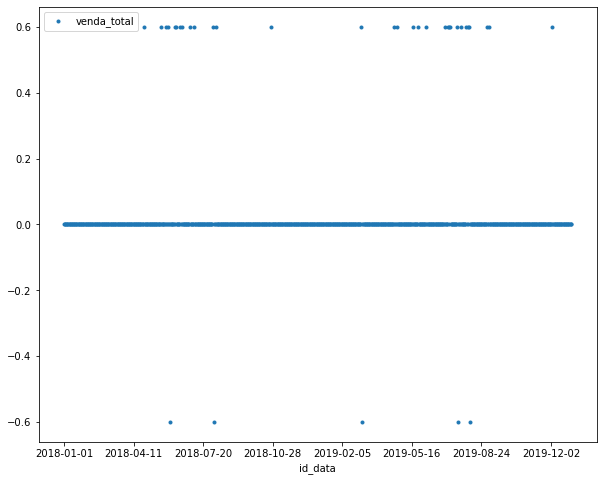

In [21]:
dados_plot.plot(x='id_data', y='venda_total', style='.', figsize=(10, 8))

Vamos plotar para o periodo de um mes: março de 2018

<AxesSubplot:xlabel='id_data'>

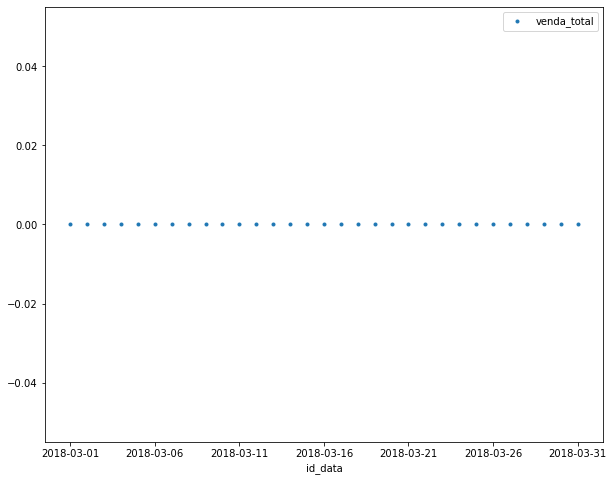

In [22]:
dados_plot.loc[(dados_plot.id_data >= "2018-03-01") & (dados_plot.id_data < "2018-04-01")]\
          .plot(x='id_data', y='venda_total', style='.', figsize=(10, 8))

Esse produto tem muitos valores nulos, esses valores provavelmente representam a nao venda daquele produto naquele dia. Isso pode atrapalhar o modelo

# Feature Engeneering
Primeiro, vamos criar features afim de conseguir obter um modelo melhor - com melhor acurácia. Posteriormente, selecionaremos quais dessas features sao de fato relevantes para a analise e devem permanecer. Nossas features devem ser capazes de detectar 
* **padrões sazonais**: padrões regulares em curtos periodos de tempo
* **padrões cíclicos**: padrões regulares em longos periodos de tempo

In [23]:
dados.groupby("produto_nome").size().reset_index().sort_values(0)

,produto_nome,0
0,Produto 1,730
9149,Produto 5462,730
9150,Produto 5463,730
9151,Produto 5464,730
9152,Produto 5465,730
...,...,...
4582,Produto 14594,730
4583,Produto 14595,730
4584,Produto 14596,730
4586,Produto 146,730


<AxesSubplot:title={'center':'Produto 7273'}, xlabel='id_data'>

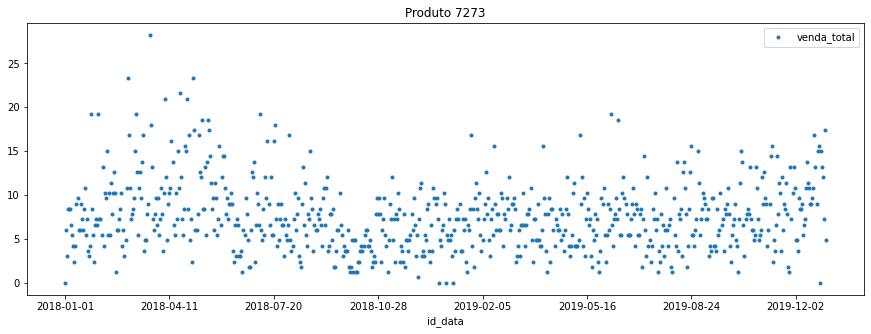

In [24]:
dados[dados['produto_nome'] == 'Produto 7273'] \
     .plot(x='id_data', y='venda_total', style='.',
          figsize=(15, 5),
          title='Produto 7273')

Vamos ver se conseguimos tirar algum tipo de tendencia

In [25]:
def media_movel_futuro(df, janelas):
    
    'calcula media movel futura'
    df = df.copy()
    df = df.iloc[::-1] #inverter tabela
    
    for window in janelas:
        #faz o media movel do "passado"
        df['venda_roll_mean_' + str(window)] = df.groupby(["produto_nome"])['venda_total']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .mean().reset_index(0,drop=True))
        
    
    return df.iloc[::-1] #inverte de volta

In [26]:
dados_7273 = dados[dados['produto_nome'] == 'Produto 7273']
dados_7273 = media_movel_futuro(dados_7273,[7,15])

In [27]:
dados_7273 

,produto_nome,id_data,venda_total,venda_roll_mean_7,venda_roll_mean_15
8019050,Produto 7273,2018-01-01,0.0,6.600000,6.44
8019051,Produto 7273,2018-01-02,6.0,6.342857,6.52
8019052,Produto 7273,2018-01-03,3.0,6.257143,6.72
8019053,Produto 7273,2018-01-04,8.4,5.657143,6.72
8019054,Produto 7273,2018-01-05,8.4,5.742857,6.88
...,...,...,...,...,...
8019775,Produto 7273,2019-12-27,13.2,NaN,NaN
8019776,Produto 7273,2019-12-28,12.0,NaN,NaN
8019777,Produto 7273,2019-12-29,7.2,NaN,NaN
8019778,Produto 7273,2019-12-30,17.4,NaN,NaN


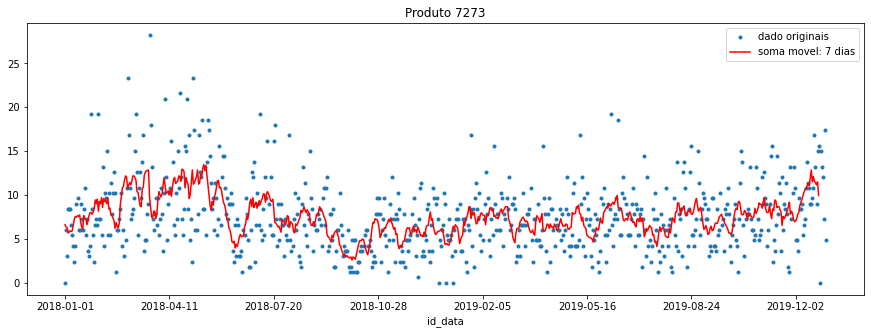

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))

dados[dados['produto_nome'] == 'Produto 7273'] \
     .plot(ax=ax, x='id_data', y='venda_total', style='.',
          title='Produto 7273', label='dado originais')

dados_7273\
     .plot(ax=ax, x='id_data', y='venda_roll_mean_7', style='-', color="red", label='soma movel: 7 dias'
          )


ax.legend()
plt.show()

Podemos ver que os dados originais nao tem padroes detectaveis. No entando, quando fazemos uma soma ou media movel, tendencias comecam a aparecer. Por esse motivo, para o modelo performar bem, utilizaremos **media ou soma movel de vendas por dia por produto como target**


## $y \equiv \text{soma movel em x dias de vendas, por dia, por produto}$

In [29]:
dados_7273 = media_movel_futuro(dados_7273,[21,30])

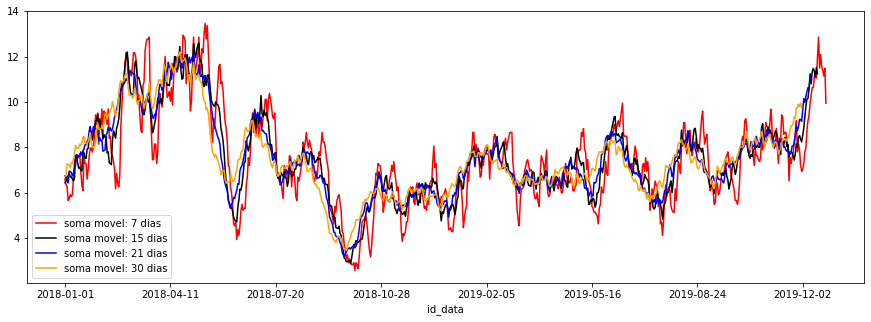

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))


dados_7273\
     .plot(ax=ax, x='id_data', y='venda_roll_mean_7', style='-', color="red", label='soma movel: 7 dias'
          )

dados_7273\
     .plot(ax=ax, x='id_data', y='venda_roll_mean_15', style='-', color="black", label='soma movel: 15 dias'
          )

dados_7273\
     .plot(ax=ax, x='id_data', y='venda_roll_mean_21', style='-', color="blue", label='soma movel: 21 dias'
          )

dados_7273\
     .plot(ax=ax, x='id_data', y='venda_roll_mean_30', style='-', color="orange", label='soma movel: 30 dias'
          )



ax.legend()
plt.show()

30 dias suaviza demais os eventos individuais, algo entre 15 e  21 arece uma boa opcao

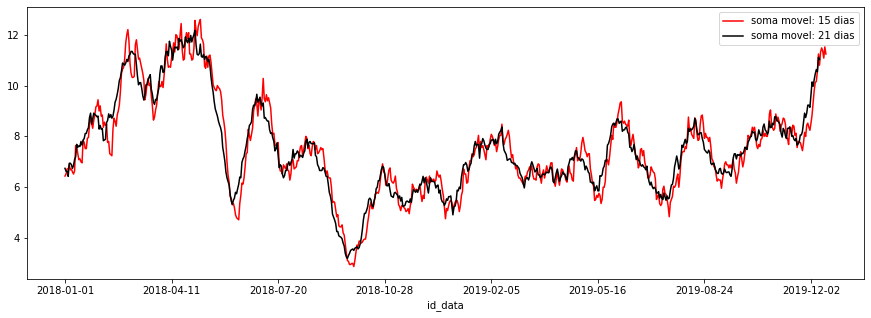

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))


dados_7273\
     .plot(ax=ax, x='id_data', y='venda_roll_mean_15', style='-', color="red", label='soma movel: 15 dias'
          )

dados_7273\
     .plot(ax=ax, x='id_data', y='venda_roll_mean_21', style='-', color="black", label='soma movel: 21 dias'
          )




ax.legend()
plt.show()

Vamos escolher 15 por praticidade: ja que o menor intervalo de tempo que iremos prever sera de 30 dias. Assim ficamos com

## $y \equiv \text{soma movel dos proximos 15 dias de vendas, por dia, por produto}$

In [32]:
### Target
def soma_movel_futuro(df, janelas):
    
    'calcula media movel futura'
    df = df.copy()
    #inverter tabela (dados recentes no inicio e dados antigos no final)
    df = df.iloc[::-1] 
    
    for window in janelas:
        #faz o media movel do "passado"
        df['target_soma_movel_' + str(window)] = df.groupby(["produto_nome"])['venda_total']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .sum().reset_index(0,drop=True))
        
    
    return df.iloc[::-1] #inverte de volta

In [33]:
dados = soma_movel_futuro(dados, [15])

In [34]:
#checando se esta tudo certo
dados[dados['produto_nome'] == 'Produto 9999'].tail(20)

,produto_nome,id_data,venda_total,target_soma_movel_15
10025800,Produto 9999,2019-12-12,0.6,6.0
10025801,Produto 9999,2019-12-13,0.0,6.6
10025802,Produto 9999,2019-12-14,0.0,6.6
10025803,Produto 9999,2019-12-15,1.2,7.2
10025804,Produto 9999,2019-12-16,0.6,7.2
10025805,Produto 9999,2019-12-17,0.6,NaN
10025806,Produto 9999,2019-12-18,0.0,NaN
10025807,Produto 9999,2019-12-19,0.6,NaN
10025808,Produto 9999,2019-12-20,0.6,NaN
10025809,Produto 9999,2019-12-21,0.6,NaN


In [35]:
dados[dados['produto_nome'] == 'Produto 9999'].tail(35)

,produto_nome,id_data,venda_total,target_soma_movel_15
10025785,Produto 9999,2019-11-27,1.2,7.2
10025786,Produto 9999,2019-11-28,0.0,7.2
10025787,Produto 9999,2019-11-29,0.0,7.2
10025788,Produto 9999,2019-11-30,0.0,8.4
10025789,Produto 9999,2019-12-01,0.6,8.4
10025790,Produto 9999,2019-12-02,1.2,7.8
10025791,Produto 9999,2019-12-03,1.2,6.6
10025792,Produto 9999,2019-12-04,0.6,6.6
10025793,Produto 9999,2019-12-05,0.0,7.2
10025794,Produto 9999,2019-12-06,0.0,7.8


## Features de tempo
Queremos features que detectem padroes cíclicos

In [36]:
#colocar datas no formato de datetime do Pandas para facilitar operacoes
dados['id_data'] = pd.to_datetime(dados.id_data, format='%Y-%m-%d')

In [37]:
def criar_features_de_tempo(dados=dados):
    """
    Cria features de series temporais.
    """
    dados = dados.copy()
    #df['hour'] = df.index.hour
    dados["diadasemana"]  = dados.id_data.dt.dayofweek
    dados["diadomês"]     = dados.id_data.dt.day
    dados["diadoano"]     = dados.id_data.dt.dayofyear
    dados["mês"]          = dados.id_data.dt.month
    dados["semanadoano"]  = dados.id_data.dt.isocalendar().week.astype("int64")
    
    # 0: Verao - 1: Outono - 2: Inverno - 3: Primavera
    dados["estação"] = np.where(dados.mês.isin([12,1,2]), 0, 1)
    dados["estação"] = np.where(dados.mês.isin([6,7,8]), 2, dados["estação"])
    dados["estação"] = np.where(dados.mês.isin([9, 10, 11]), 3, dados["estação"])

    return dados

In [38]:
dados1 = criar_features_de_tempo()
dados1.reset_index()

,index,produto_nome,id_data,venda_total,target_soma_movel_15,diadasemana,diadomês,diadoano,mês,semanadoano,estação
0,0,Produto 1,2018-01-01,0.0,1.2,0,1,1,1,1,0
1,1,Produto 1,2018-01-02,0.0,1.2,1,2,2,1,1,0
2,2,Produto 1,2018-01-03,0.0,1.2,2,3,3,1,1,0
3,3,Produto 1,2018-01-04,0.6,0.6,3,4,4,1,1,0
4,4,Produto 1,2018-01-05,0.0,1.2,4,5,5,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
10025815,10025815,Produto 9999,2019-12-27,1.2,NaN,4,27,361,12,52,0
10025816,10025816,Produto 9999,2019-12-28,0.6,NaN,5,28,362,12,52,0
10025817,10025817,Produto 9999,2019-12-29,0.0,NaN,6,29,363,12,52,0
10025818,10025818,Produto 9999,2019-12-30,1.8,NaN,0,30,364,12,1,0


## Introduzir Lag Features
Lag features são valores em tempos anteriores que são consideradas úteis por assumirmos que o que aconteceu no passado pode influenciar ou reter algum tipo de informação intrínseca sobre o futuro.

Lembrando que capturar a tendencia e sazonalidade é o nosso objetivo principal

In [39]:
def lag_features(df, lags):
    for lag in lags:
        df['lag_vendas_' + str(lag)] = df.groupby(["produto_nome"])['target_soma_movel_15']\
                                         .transform(lambda x: x.shift(lag))
    return df

In [40]:
#o spam de tempo que queremos calcular é de 30, 60, 90 dias, 
#o banco de dados vai ate 730 dias, entao
#vamos adicionar multiplos de 30, 60, 90, ate 90 dias 
#para nao perdermos muitos dados no conjunto de teste

lags = np.arange(7, 95, 7)

In [41]:
dados1 = lag_features(dados1, lags)
dados1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10025820 entries, 0 to 10025819
Data columns (total 23 columns):
 #   Column                Dtype         
---  ------                -----         
 0   produto_nome          object        
 1   id_data               datetime64[ns]
 2   venda_total           float64       
 3   target_soma_movel_15  float64       
 4   diadasemana           int64         
 5   diadomês              int64         
 6   diadoano              int64         
 7   mês                   int64         
 8   semanadoano           int64         
 9   estação               int64         
 10  lag_vendas_7          float64       
 11  lag_vendas_14         float64       
 12  lag_vendas_21         float64       
 13  lag_vendas_28         float64       
 14  lag_vendas_35         float64       
 15  lag_vendas_42         float64       
 16  lag_vendas_49         float64       
 17  lag_vendas_56         float64       
 18  lag_vendas_63         float64       
 19

## Features de média movel
Vamos calcular a média movel. Esse tipo de é bom para remover as pequenas variações entre time steps - cria uma versao suavizada do dataset

In [42]:
def features_media_mov(df, janelas):
    for window in janelas:
        df['venda_media_movel_' + str(window)] = df.groupby(["produto_nome"])['venda_total']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .mean())
    return df

In [43]:
janelas = [7, 15, 35, 65, 95, 120]

Pra evitar que a previsao fique ruim, vou considerar janelas maiores que 90 dias, de forma que quando fizer a previsao de 90 dias, eu consiga considerar parte dos valores do conjunto de dados para fazer a media (e nao fazer a media apenas nos valores que o modelo prever)

In [44]:
dados1= features_media_mov(dados1, janelas)

In [45]:
dados1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10025820 entries, 0 to 10025819
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   produto_nome           object        
 1   id_data                datetime64[ns]
 2   venda_total            float64       
 3   target_soma_movel_15   float64       
 4   diadasemana            int64         
 5   diadomês               int64         
 6   diadoano               int64         
 7   mês                    int64         
 8   semanadoano            int64         
 9   estação                int64         
 10  lag_vendas_7           float64       
 11  lag_vendas_14          float64       
 12  lag_vendas_21          float64       
 13  lag_vendas_28          float64       
 14  lag_vendas_35          float64       
 15  lag_vendas_42          float64       
 16  lag_vendas_49          float64       
 17  lag_vendas_56          float64       
 18  lag_vendas_63       

# Training, validacao e Test Split
A maior janela é de 120 dias, entao a janela de treino começara no dia 180 
Faremos validacao cruzada de uma forma diferente com a qual estamos separando conjuntos de treino e teste

In [46]:
train = dados1[dados1['id_data'].between("2018-05-01","2019-07-01")] #~10^6 linhas!
cv    = dados1[dados1['id_data'].between("2019-07-02","2019-10-01")]
test  = dados1[dados1['id_data'].between("2019-10-02","2019-12-31")]

In [47]:
#train = train.sample(5*10**5, random_state=123)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5864418 entries, 120 to 10025636
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   produto_nome           object        
 1   id_data                datetime64[ns]
 2   venda_total            float64       
 3   target_soma_movel_15   float64       
 4   diadasemana            int64         
 5   diadomês               int64         
 6   diadoano               int64         
 7   mês                    int64         
 8   semanadoano            int64         
 9   estação                int64         
 10  lag_vendas_7           float64       
 11  lag_vendas_14          float64       
 12  lag_vendas_21          float64       
 13  lag_vendas_28          float64       
 14  lag_vendas_35          float64       
 15  lag_vendas_42          float64       
 16  lag_vendas_49          float64       
 17  lag_vendas_56          float64       
 18  lag_vendas_63      

# Analise de Outliers

In [48]:
train.groupby(["produto_nome"]).agg({"target_soma_movel_15": ["count","sum", "mean", "median", "std", "min", "max"]})

target_soma_movel_15                                             \
                             count      sum       mean median       std   min   
produto_nome                                                                    
Produto 1                      427     69.6   0.162998    0.0  0.392701   0.0   
Produto 100                    427    697.2   1.632787    1.2  1.096153   0.0   
Produto 10000                  427    648.0   1.517564    1.2  1.097135   0.0   
Produto 10001                  427   1315.8   3.081499    3.0  1.576265   0.0   
Produto 10002                  427   1396.2   3.269789    0.6  3.948364   0.0   
...                            ...      ...        ...    ...       ...   ...   
Produto 9995                   427   1247.4   2.921311    3.0  1.686731   0.0   
Produto 9996                   427  17381.4  40.705855   39.0  8.351393  24.0   
Produto 9997                   427    151.2   0.354098    0.0  0.426527   0.0   
Produto 9998                   427    555.0   1.299766    1.2  1.051837   0.0   
Produto 9999                   427   2960.4   6.933021    6.6  2.170245   1.8   

                     
                max  
produto_nome         
Produto 1       2.4  
Produto 100     4.2  
Produto 10000   5.4  
Produto 10001   8.4  
Produto 10002  15.6  
...             ...  
Produto 9995    7.2  
Produto 9996   61.8  
Produto 9997    1.2  
Produto 9998    5.4  
Produto 9999   13.2  

[13734 rows x 7 columns]

<AxesSubplot:ylabel='Frequency'>

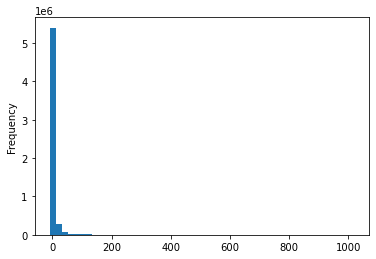

In [49]:
train["target_soma_movel_15"].plot(kind='hist', bins=50)

In [50]:
print("Numero max de vendas de todos os produtos por dia:", train["target_soma_movel_15"].max(),"\n",\
      "Numero min de vendas de todos os produtos por dia:", train["target_soma_movel_15"].min())

Numero max de vendas de todos os produtos por dia: 1019.4 
 Numero min de vendas de todos os produtos por dia: -9.0


In [51]:
print(train.query('target_soma_movel_15 < 0').count()['target_soma_movel_15'],\
      train.query('target_soma_movel_15 > 200').count()['target_soma_movel_15'])

23295 25058


<AxesSubplot:title={'center':'Outliers'}, xlabel='id_data'>

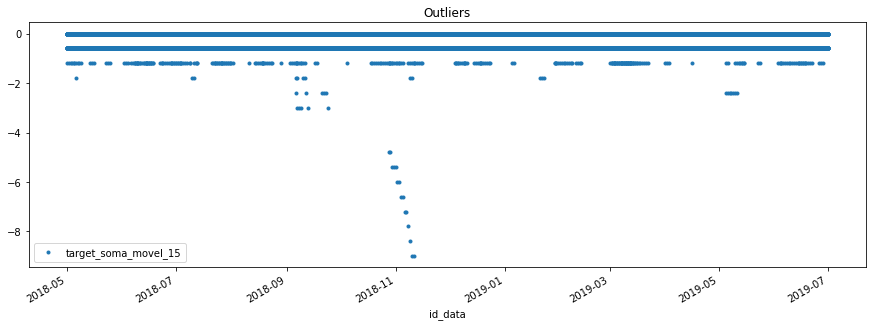

In [52]:
train.query('target_soma_movel_15 < 0') \
    .plot(x='id_data', y='target_soma_movel_15', style='.',
          figsize=(15, 5),
          title='Outliers')

Remover esses dados estranho do periodo de nov 2018

<AxesSubplot:title={'center':'Outliers'}, xlabel='id_data'>

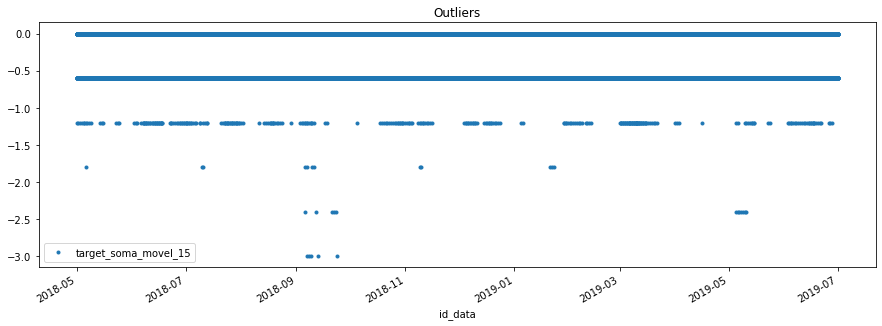

In [53]:
train = train.query('target_soma_movel_15 > -4').copy() #remover outlier

#plotar nova distribuicao
train.query('target_soma_movel_15 < 0') \
    .plot(x='id_data', y='target_soma_movel_15', style='.',
          figsize=(15, 5),
          title='Outliers')

<AxesSubplot:title={'center':'Outliers'}, xlabel='id_data'>

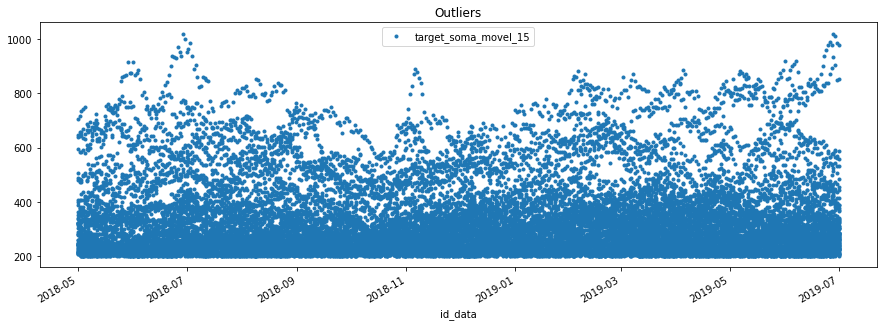

In [54]:
train.query('target_soma_movel_15 > 200') \
    .plot(x='id_data', y='target_soma_movel_15', style='.',
          figsize=(15, 5),
          title='Outliers')

Nao parece haver nada de visilvelmente anormaal aqui. Vamos manter todos os dados

# Categorical Encoding
Vamos transformar as colunas de *categorias* (colunas que mesmo se representadas por numeros, os numeros nao tem valor quantitativo):
* produto_nome
* diadasemana
* diadomês 
* diadoano 
* mês 
* semanadoano
* estação

em colunas binarias para que o modelo funcione.


In [55]:
#como produto_nome tem milhares de categorias, antes de aplicar a transformacao vamos
#ver quanto de nosso dataframe ocupa
BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")
    
print_memory_usage_of_data_frame(train)

Memory usage is 1407.457 MB


o dataframe transformado vai ocupar muito mais do que o dataframe original ocupa de RAM. Portanto, vamos tentar aliviar esse efeito usando **TARGET ENCODING**.


## Target Encoder
A ideia principal aqui é fazer um encode das categorias por substitui-las por uma *medida do efeito que elas terao na target* venda_total por produto por dia


Vamos substituir a categoria pelo valor da média do target para aquela categoria e, para evitar overfitting, vamos fazer **additive smoothing** 

### Additive Smoothing
"Suavizar” a media ao incluir as vendas de *todos os produtos*

# $\mu = \frac{n\times\bar{x}\,+\,m\times w}{n+m}$
onde
* $\mu$ é a média que vai substituir os valores categoricos
* $n$ é o numero de valores
* $\bar{x}$ é a media estimada para a categoria
* $m$ é o peso que vamos associar à media total. Quanto maior m maior o peso da media total
* $w$ é a media total

In [56]:
def calc_media_suave(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [57]:
train_encod = train.copy()

# o encoding do test e cv deve ser basado no target encoding para o conj. de treino 
cv_encod    = cv.copy()
test_encod  = test.copy()

In [58]:
features = ["produto_nome",
"diadasemana",
"diadomês",
"diadoano",
"mês",
"semanadoano",
"estação"] 

novas_features = ["Nproduto_nome",
"Ndiadasemana",
"Ndiadomês",
"Ndiadoano",
"Nmês",
"Nsemanadoano",
"Nestação"] 

In [59]:
m = 100
for i in range(len(features)):

    train_encod[ novas_features[i] ]=calc_media_suave(train_encod, by=features[i], on='target_soma_movel_15', m=m)
#m=100 chute inicial

In [60]:
print_memory_usage_of_data_frame(train_encod)

Memory usage is 1871.13 MB


In [61]:
train_encod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5864403 entries, 120 to 10025636
Data columns (total 36 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   produto_nome           object        
 1   id_data                datetime64[ns]
 2   venda_total            float64       
 3   target_soma_movel_15   float64       
 4   diadasemana            int64         
 5   diadomês               int64         
 6   diadoano               int64         
 7   mês                    int64         
 8   semanadoano            int64         
 9   estação                int64         
 10  lag_vendas_7           float64       
 11  lag_vendas_14          float64       
 12  lag_vendas_21          float64       
 13  lag_vendas_28          float64       
 14  lag_vendas_35          float64       
 15  lag_vendas_42          float64       
 16  lag_vendas_49          float64       
 17  lag_vendas_56          float64       
 18  lag_vendas_63      

criar tabelas de correspondencia entre valor e categoria e aplicalas nos conj de teste e cv

In [62]:
corresp_prod    = train_encod.groupby(['produto_nome', 'Nproduto_nome'])\
                             .size().reset_index()[['produto_nome', 'Nproduto_nome']]

corresp_semana  = train_encod.groupby(['diadasemana', 'Ndiadasemana'])\
                             .size().reset_index()[['diadasemana', 'Ndiadasemana']]

corresp_dmes     = train_encod.groupby(['diadomês', 'Ndiadomês'])\
                             .size().reset_index()[['diadomês', 'Ndiadomês']]
 
corresp_ano     = train_encod.groupby(['diadoano', 'Ndiadoano'])\
                             .size().reset_index()[['diadoano', 'Ndiadoano']]

corresp_mes     = train_encod.groupby(['mês', 'Nmês'])\
                             .size().reset_index()[['mês', 'Nmês']]

corresp_sem_ano = train_encod.groupby(['semanadoano', 'Nsemanadoano'])\
                             .size().reset_index()[['semanadoano', 'Nsemanadoano']]

corresp_estacao =train_encod.groupby(['estação', 'Nestação'])\
                             .size().reset_index()[['estação', 'Nestação']]

In [63]:
corresp = [corresp_prod, corresp_semana, corresp_dmes, corresp_ano, corresp_mes, corresp_sem_ano, corresp_estacao]

In [64]:
for i in range(len(features)):
    test_encod = test_encod.merge(corresp[i], on=features[i], how="left")
    cv_encod   = cv_encod.merge(corresp[i], on=features[i], how="left")

In [65]:
# remover features categoricas, deixando apenas os seus encoded values
for i in range(len(features)):
    test_encod.drop(features[i], axis=1, inplace=True)
    cv_encod.drop(features[i], axis=1, inplace=True)
    train_encod.drop(features[i], axis=1, inplace=True)

In [66]:
test_encod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249794 entries, 0 to 1249793
Data columns (total 29 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id_data                1249794 non-null  datetime64[ns]
 1   venda_total            1249794 non-null  float64       
 2   target_soma_movel_15   1043784 non-null  float64       
 3   lag_vendas_7           1139922 non-null  float64       
 4   lag_vendas_14          1236060 non-null  float64       
 5   lag_vendas_21          1249794 non-null  float64       
 6   lag_vendas_28          1249794 non-null  float64       
 7   lag_vendas_35          1249794 non-null  float64       
 8   lag_vendas_42          1249794 non-null  float64       
 9   lag_vendas_49          1249794 non-null  float64       
 10  lag_vendas_56          1249794 non-null  float64       
 11  lag_vendas_63          1249794 non-null  float64       
 12  lag_vendas_70          12497

# CrossValidation Split

In [67]:
tss = TimeSeriesSplit(n_splits=5)#, max_train_size=5000000)
dados2 = train_encod

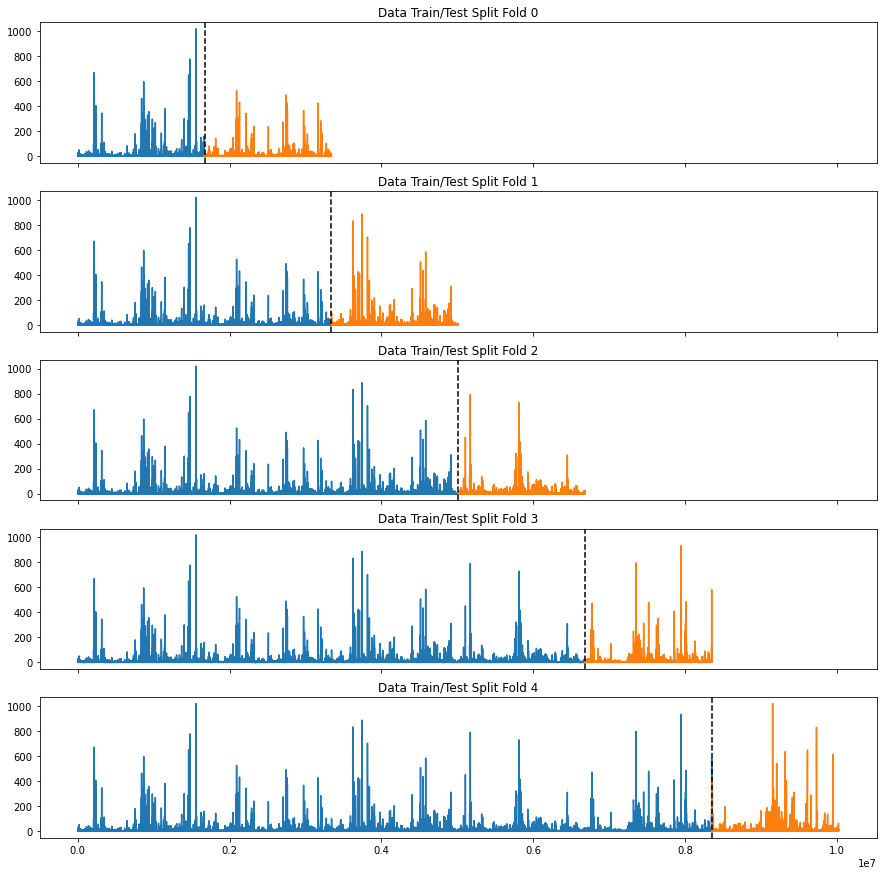

In [68]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(dados2):
    train1 = dados2.iloc[train_idx]
    test1 = dados2.iloc[val_idx]
    train1['target_soma_movel_15'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test1['target_soma_movel_15'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test1.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Criando modelo: XGBReg

## Treinando com validacao cruzada

In [ ]:
FEATURES = list(dados2.columns)
remover = ['id_data',
 'venda_total',
 'target_soma_movel_15']

for i in remover:
    FEATURES.remove(i)
    
TARGET = ['target_soma_movel_15']

In [ ]:
tss = TimeSeriesSplit(n_splits=5)
#df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train1 = dados2.iloc[train_idx]
    val = dados2.iloc[val_idx]

    X_train = train1[FEATURES]
    Y_train = train1[TARGET]

    X_val = val[FEATURES]
    Y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           #bjective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_val, Y_val)],
            verbose=100)

    Y_pred = reg.predict(X_val)
    preds.append(Y_pred)
    score = np.sqrt(mean_squared_error(Y_val, Y_pred))
    scores.append(score)

In [ ]:
scores

## Tunning de Hiperparametros

In [73]:
z

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043784 entries, 0 to 1249778
Data columns (total 29 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id_data                1043784 non-null  datetime64[ns]
 1   venda_total            1043784 non-null  float64       
 2   target_soma_movel_15   1043784 non-null  float64       
 3   lag_vendas_7           1043784 non-null  float64       
 4   lag_vendas_14          1043784 non-null  float64       
 5   lag_vendas_21          1043784 non-null  float64       
 6   lag_vendas_28          1043784 non-null  float64       
 7   lag_vendas_35          1043784 non-null  float64       
 8   lag_vendas_42          1043784 non-null  float64       
 9   lag_vendas_49          1043784 non-null  float64       
 10  lag_vendas_56          1043784 non-null  float64       
 11  lag_vendas_63          1043784 non-null  float64       
 12  lag_vendas_70          10437

In [74]:
X_train = train_encod.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_train = train_encod["target_soma_movel_15"]

X_val = cv_encod.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_val = cv_encod["target_soma_movel_15"]

X_test = test3.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_test = test3["target_soma_movel_15"]

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(5864403, 26) (5864403,) (1263528, 26) (1263528,)


In [75]:
%%time
regrXGB = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.008)


regrXGB.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_val, Y_val)],
        verbose=100)

[04:40:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:26.64342	validation_1-rmse:28.30709
[100]	validation_0-rmse:13.19395	validation_1-rmse:14.95431
[200]	validation_0-rmse:7.83288	validation_1-rmse:10.10113
[300]	validation_0-rmse:6.03409	validation_1-rmse:8.60049
[400]	validation_0-rmse:5.46106	validation_1-rmse:8.14831
[500]	validation_0-rmse:5.26732	validation_1-rmse:8.01842
[600]	validation_0-rmse:5.18184	validation_1-rmse:7.92622
[698]	validation_0-rmse:5.13792	validation_1-rmse:7.91163
CPU times: user 29min 17s, sys: 1min 3s, total: 30min 20s
Wall time: 4min 49s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [76]:
def smape(previsao, dado):
    return 100/len(dado) * np.sum(np.abs(previsao - dado) / (np.abs(dado) + np.abs(previsao)))

In [77]:
def print_metrics(X, Y):
    print( "SMAPE:", smape(regrXGB.predict(X), Y) )
    print("\tMean absolute error (MAE):", mean_absolute_error(Y, regrXGB.predict(X)))
    print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(Y, regrXGB.predict(X))))
    print("\tR2 score:", r2_score(Y, regrXGB.predict(X)))
    
    return

In [78]:
#train metrics
print_metrics(X_train, Y_train)

SMAPE: 63.48218380863101
	Mean absolute error (MAE): 1.0900100778099229
	Root Mean squared error (RMSE): 5.1559762693389315
	R2 score: 0.9618794895720214


In [79]:
#test metrics
print_metrics(X_val, Y_val)

SMAPE: 62.522039904515786
	Mean absolute error (MAE): 1.2204762539811869
	Root Mean squared error (RMSE): 7.905752561084061
	R2 score: 0.920676905256377


In [80]:
#test metrics
print_metrics(X_test, Y_test)

SMAPE: 61.33229710421155
	Mean absolute error (MAE): 1.4029356889488647
	Root Mean squared error (RMSE): 9.512090812059796
	R2 score: 0.9044532246442785


In [81]:
Y_train.describe().reset_index() #comparar metricas com as estatisticas do dado

,index,target_soma_movel_15
0,count,5.864403e+06
1,mean,5.324105e+00
2,std,2.640776e+01
3,min,-3.000000e+00
4,25%,0.000000e+00
5,50%,0.000000e+00
6,75%,2.400000e+00
7,max,1.019400e+03


O R2 parece ótimo para os conjuntos de validacao, treino e teste. MAE é menos do que o valor médio da target. No entanto, SMAPE parece bem problematico. Vamos plotar o fit em cima dos dados pra ajudar a entender se o modelo esta bom ou nao.

## Plotar Resultado

In [82]:
previsao_val = regrXGB.predict(X_val)
previsao_train = regrXGB.predict(X_train)
#previsao_test = regrXGB.predict(X_test)

In [83]:
#test4 = test.dropna()

In [84]:
cv['previsao'] = previsao_val
train['previsao'] = previsao_train
#test4['previsao'] = previsao_test

<ipython-input-84-537b36b133f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['previsao'] = previsao_val


In [85]:
cv_7273 = cv[cv['produto_nome'] == 'Produto 7273']
train_7273 = train[train['produto_nome'] == 'Produto 7273']
#test_7273 = test4[test4['produto_nome'] == 'Produto 7273']

In [86]:
def plot_resultados(df):
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(df['id_data'], df['target_soma_movel_15'], color="black", label='resultado verdadeiro '
              )
    ax.plot(df['id_data'], df['previsao'], color="red", label='previsao teste'
              )


    ax.legend()
    plt.show()

    return

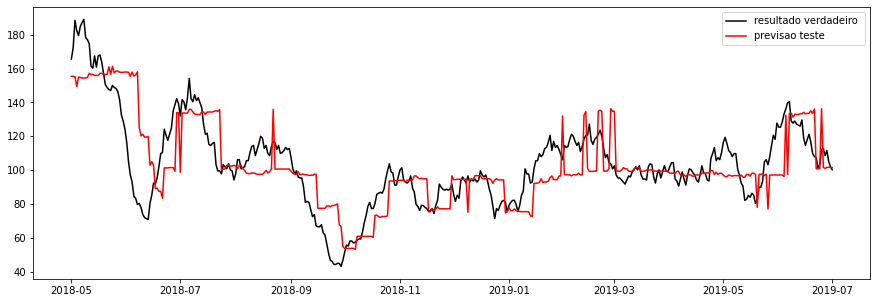

In [87]:
#treino
plot_resultados(train_7273)

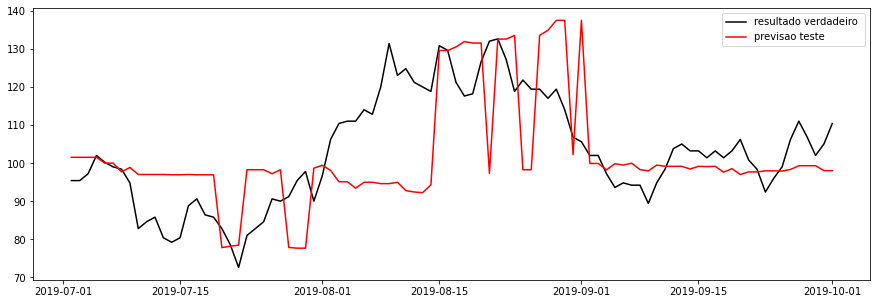

In [88]:
#validacao
plot_resultados(cv_7273)

Olhando para o plot, podemos entender porque o SMAPE estava ruim e o R2 bom. Os modelos estao com formas bem quadradas e com muita dificuldade de generalizacao! Provavelmente o modelo esta fitando um monte de zeros

Na etapa de analise do banco de dados, nos ja tinhamos visto que temos poucos valores de venda por produto (ate 730 pontos) e alem disso, muitos desses produtos tem muitos valores nulos!

Isso indica duas possibilidades para esse overfitting: **curse of dimensionality** e **sparse data**

Antes de atacar esses dois pontos, vamos dar uma olhada na importancia das features para termos mais insights.

## Importância da feature

In [89]:
feature_importance= pd.DataFrame(data   = regrXGB.feature_importances_,
                 index  = regrXGB.feature_names_in_,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(25)

,importance
lag_vendas_7,0.418298
venda_media_movel_35,0.372155
lag_vendas_21,0.067473
Nproduto_nome,0.038320
venda_media_movel_65,0.037270
lag_vendas_91,0.011497
lag_vendas_42,0.009646
lag_vendas_49,0.007047
lag_vendas_28,0.005345
venda_media_movel_95,0.004973


<Figure size 720x360 with 0 Axes>

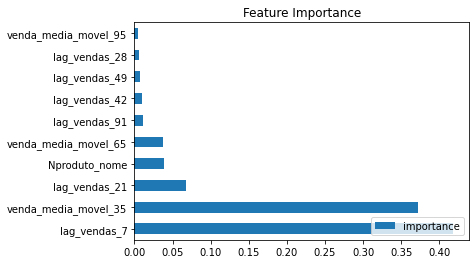

In [90]:
plt.figure(figsize=(10, 5))
fi = feature_importance.sort_values('importance', ascending=False).head(10)
fi.plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

In [91]:
rs = np.random.RandomState(0)
df = pd.DataFrame(X_train[['Nproduto_nome','venda_media_movel_95','venda_media_movel_120']])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Nproduto_nome,venda_media_movel_95,venda_media_movel_120
Nproduto_nome,1.000000,0.976905,0.978070
venda_media_movel_95,0.976905,1.000000,0.998583
venda_media_movel_120,0.978070,0.998583,1.000000


Ate agora, fitamos o modelo para todos os produtos ao mesmo tempo e vimos que nao conseguimos capturar as tendencias da serie temporal. Sabemos que temos por volta de 15000 produtos, muitos deles, com muitos zeros. Pode nao ser o ideal, mas reduzir o numero de produtos para, por exemplo os 100 mais vendidos e concatenar os demais, pode melhorar os resultados do modelo..  

Mas para ver se essa hipotese faz sentido, vamos primeiro ver se o modelo XGBoost é capaz de modelar bem quando **fitado para apenas 1 produto**

## Fitar modelo em um produto

In [92]:
a = float(corresp_prod[corresp_prod["produto_nome"] == "Produto 7273"]['Nproduto_nome'])

In [93]:
#fitar em um dado

train1_7273 = train_encod[train_encod['Nproduto_nome'] == a]
val1_7273 = cv_encod[cv_encod['Nproduto_nome'] == a]


X_train_7273 = train1_7273.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_train_7273 = train1_7273['target_soma_movel_15']

X_val_7273 = val1_7273.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_val_7273 = val1_7273['target_soma_movel_15']


In [94]:
%%time
regrXGB = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=5000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=2,
                           reg_lambda= 10, #acrescentar um L2 alto para ver se conseguimos evitar overvitting
                           learning_rate=0.008)

CPU times: user 29 µs, sys: 6 µs, total: 35 µs
Wall time: 38.1 µs


In [95]:
regrXGB.fit(X_train_7273, Y_train_7273,
        eval_set=[(X_train_7273, Y_train_7273), (X_val_7273, Y_val_7273)],
        verbose=100)


[04:45:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:105.39975	validation_1-rmse:102.74939
[100]	validation_0-rmse:51.54776	validation_1-rmse:48.13292
[200]	validation_0-rmse:27.12232	validation_1-rmse:25.75525
[300]	validation_0-rmse:16.22414	validation_1-rmse:17.05923
[400]	validation_0-rmse:11.62726	validation_1-rmse:14.11589
[500]	validation_0-rmse:9.64640	validation_1-rmse:13.18401
[600]	validation_0-rmse:8.59506	validation_1-rmse:12.87880
[651]	validation_0-rmse:8.17049	validation_1-rmse:12.94246


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [96]:
#validation
print_metrics(X_val_7273, Y_val_7273)

SMAPE: 5.523887080207687
	Mean absolute error (MAE): 11.034407093213943
	Root Mean squared error (RMSE): 12.876092435106196
	R2 score: 0.1903874434329318


In [97]:
#Train
print_metrics(X_train_7273, Y_train_7273)

SMAPE: 3.454771619668702
	Mean absolute error (MAE): 6.721504164970446
	Root Mean squared error (RMSE): 8.587890643504545
	R2 score: 0.886923787996996


**Overfitting peranece** mesmo com parametro de Regularizacao L2 alto! No entanto, o SMAPE melhorou consideravelmente. Vamos ver o que aconteceu com um plot

In [98]:

val1_7273['previsao'] = regrXGB.predict(X_val_7273)
train1_7273['previsao'] = regrXGB.predict(X_train_7273)


<ipython-input-98-fa0f2a2c3375>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val1_7273['previsao'] = regrXGB.predict(X_val_7273)
<ipython-input-98-fa0f2a2c3375>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1_7273['previsao'] = regrXGB.predict(X_train_7273)


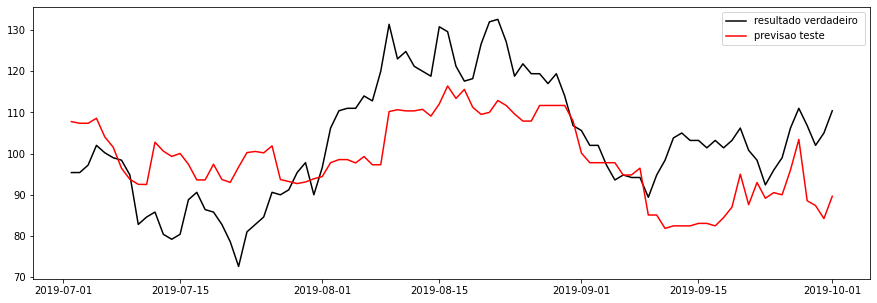

In [99]:
#validacao
plot_resultados(val1_7273)

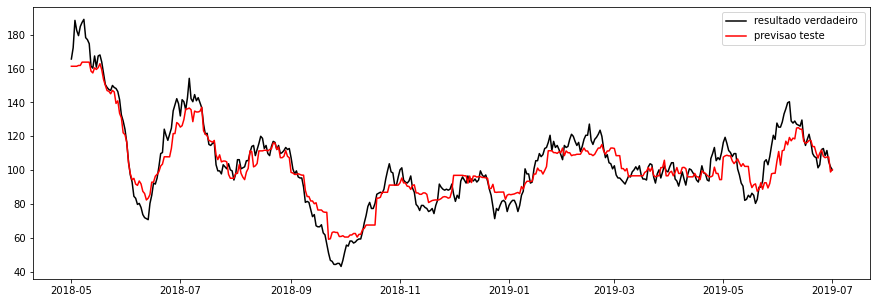

In [100]:
#treino
plot_resultados(train1_7273)

Vemos que aquele padrao "quadrado" do modelo desapareceu. Esses plots junto com a metrica me dizem que provavelmente a grande quantidade de produtos com poucos pontos é um problema. No entanto, a permanencia do overfitting mesmo com regularizacao, parece apontar para o problema de **curse of dimensionaality**. Pra atacar a **curse of dimensionality** eu penso em duas opcoes imediatas:

* 1. Testar o modelo xgboost com menos dimensoes (remover features menos importantes e ver como o modelo se comporta)
* 2. Caso 1 nao funcione, tentar um modelo estatistico para a serie temporal

In [ ]:
feature_importance= pd.DataFrame(data   = regrXGB.feature_importances_,
                 index  = regrXGB.feature_names_in_,
                 columns= ['importance'])

<Figure size 720x360 with 0 Axes>

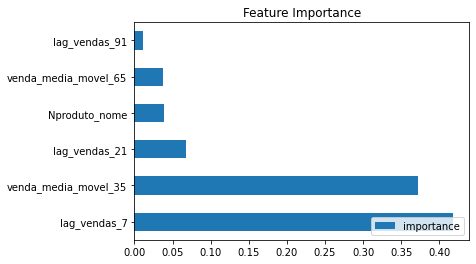

In [101]:
plt.figure(figsize=(10, 5))
fi = feature_importance.sort_values('importance', ascending=False).head(6)
fi.plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

### Reducao de dimensao
Fazer um PCA provavelmente seria uma solucao mais elegante, que podemos implementar no futuro, mas por hora, vamos somente manter as 5 features mais importantes

In [102]:
#testar modelo com as 5 features mais importantes
X2_train_7273 = X_train_7273[["lag_vendas_7", "lag_vendas_21", "venda_media_movel_35",\
                            "venda_media_movel_65", "Nproduto_nome"]]

X2_val_7273 = X_val_7273[["lag_vendas_7", "lag_vendas_21", "venda_media_movel_35",\
                            "venda_media_movel_65", "Nproduto_nome"]]

In [103]:
regrXGB.fit(X2_train_7273, Y_train_7273,
        eval_set=[(X2_train_7273, Y_train_7273), (X2_val_7273, Y_val_7273)],
        verbose=100)

[04:45:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:105.39975	validation_1-rmse:102.74939
[100]	validation_0-rmse:51.60759	validation_1-rmse:47.72284
[200]	validation_0-rmse:27.51444	validation_1-rmse:24.57393
[300]	validation_0-rmse:17.09997	validation_1-rmse:15.48310
[400]	validation_0-rmse:12.93175	validation_1-rmse:12.40058
[500]	validation_0-rmse:11.22371	validation_1-rmse:11.18390
[600]	validation_0-rmse:10.35524	validation_1-rmse:10.64536
[700]	validation_0-rmse:9.80792	validation_1-rmse:10.39952
[800]	validation_0-rmse:9.41577	validation_1-rmse:10.20049
[900]	validation_0-rmse:9.10940	validation_1-rmse:10.02868
[1000]	validation_0-rmse:8.84174	validation_1-rmse:9.91978
[1100]	validation_0-rmse:8.60971	validation_1-rmse:9.83384
[1200]	validation_0-rmse:8.39962	validation_1-rmse:9.75048
[1300]	vali

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [104]:
#validacao
print_metrics(X2_val_7273, Y_val_7273)

SMAPE: 4.042957303212774
	Mean absolute error (MAE): 8.166885558418599
	Root Mean squared error (RMSE): 9.700529473675617
	R2 score: 0.5404847353759537


In [105]:
#train
print_metrics(X2_train_7273, Y_train_7273)

SMAPE: 3.2883026724084847
	Mean absolute error (MAE): 6.3180717772008075
	Root Mean squared error (RMSE): 8.211653328208673
	R2 score: 0.8966145426826251


RMSE e MAE mostram que manter apenas as 5 features mais importantes melhora consideravelment melhora no problema de overfitting! Os valores de SMAPE tambem melhoraram e o R2 do conjunto de validacao tambem mostra uma expressiva **melhora na generalizacao**!!

### Plotar resultados

In [106]:
train2_7273 = train_encod[train_encod['Nproduto_nome'] == a]
val2_7273 = cv_encod[cv_encod['Nproduto_nome'] == a]

val2_7273['previsao'] = regrXGB.predict(X2_val_7273)
train2_7273['previsao'] = regrXGB.predict(X2_train_7273)
#test4['previsao'] = previsao_test

<ipython-input-106-5e5011fe3392>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val2_7273['previsao'] = regrXGB.predict(X2_val_7273)
<ipython-input-106-5e5011fe3392>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2_7273['previsao'] = regrXGB.predict(X2_train_7273)


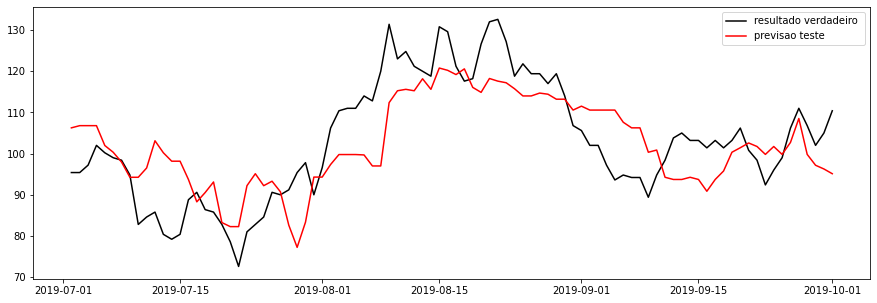

In [107]:
#validacao
plot_resultados(val2_7273)

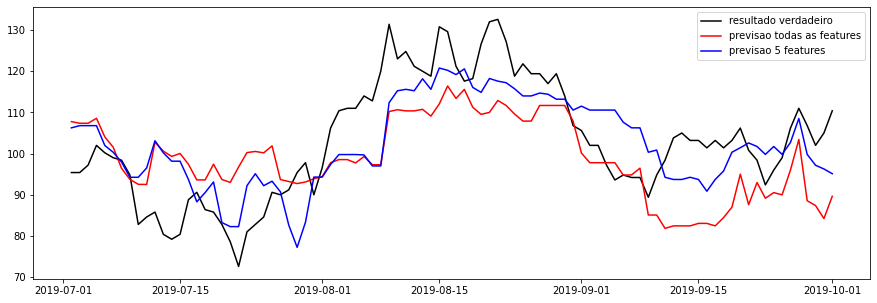

In [108]:
#comparar com e sem a reducao de dimensao
#validacao
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(val1_7273['id_data'], val1_7273['target_soma_movel_15'], color="black", label='resultado verdadeiro '
          )
ax.plot(val1_7273['id_data'], val1_7273['previsao'], color="red", label='previsao todas as features'
          )
ax.plot(val1_7273['id_data'], val2_7273['previsao'], color="blue", label='previsao 5 features'
          )


ax.legend()
plt.show()

com essas 5 features, as amplitudes da previsao se aproximam mais da dos dados

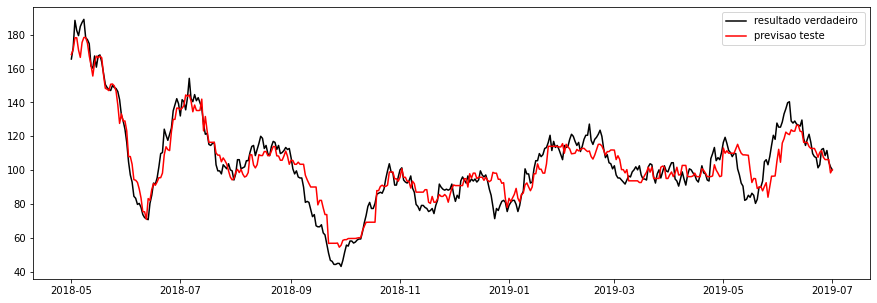

In [109]:
#treino
plot_resultados(train2_7273)

essao sao os resultados ao fitar *um produto* agora vamos ver as melhoras que obtemos atravez da reducao de dimensao com todos os produtos ao mesmo tempo!

## Modelo com dimensoes reduzidas!

In [110]:
#modificar X_train e X_val

X_train_reduzido = X_train[["lag_vendas_7", "lag_vendas_21", "venda_media_movel_35",\
                            "venda_media_movel_65", "Nproduto_nome"]]


X_val_reduzido   =  X_val[["lag_vendas_7", "lag_vendas_21", "venda_media_movel_35",\
                            "venda_media_movel_65", "Nproduto_nome"]]

In [111]:
X_train_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5864403 entries, 120 to 10025636
Data columns (total 5 columns):
 #   Column                Dtype  
---  ------                -----  
 0   lag_vendas_7          float64
 1   lag_vendas_21         float64
 2   venda_media_movel_35  float64
 3   venda_media_movel_65  float64
 4   Nproduto_nome         float64
dtypes: float64(5)
memory usage: 397.5 MB


In [112]:
regrXGB = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=2,    #arvores mais rasas para evitar overvitting
                           reg_lambda= 10, #acrescentar um L2 alto para ver se conseguimos evitar overvitting
                           learning_rate=0.008)

In [113]:
%%time

regrXGB.fit(X_train_reduzido, Y_train, 
        eval_set=[(X_train_reduzido, Y_train), (X_val_reduzido, Y_val)],
        verbose=100)

[04:46:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:26.66010	validation_1-rmse:28.32302
[100]	validation_0-rmse:14.08667	validation_1-rmse:15.74349
[200]	validation_0-rmse:8.62284	validation_1-rmse:10.63183
[300]	validation_0-rmse:6.51577	validation_1-rmse:8.88306
[400]	validation_0-rmse:5.79761	validation_1-rmse:8.34687
[500]	validation_0-rmse:5.55939	validation_1-rmse:8.16216
[600]	validation_0-rmse:5.46608	validation_1-rmse:8.08659
[700]	validation_0-rmse:5.42481	validation_1-rmse:8.06613
[800]	validation_0-rmse:5.40350	validation_1-rmse:8.05417
[900]	validation_0-rmse:5.39133	validation_1-rmse:8.05293
[911]	validation_0-rmse:5.39016	validation_1-rmse:8.05253
CPU times: user 35min 38s, sys: 1min 4s, total: 36min 43s
Wall time: 5min 38s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [115]:
regrXGB.predict(X_train_reduzido)

array([0.13011229, 0.13011229, 0.13011229, ..., 6.1356106 , 6.5834384 ,
       6.593792  ], dtype=float32)

In [ ]:
5864403, 5864403

In [116]:
cv_reduzido    = cv.drop('previsao', axis=1) 
train_reduzido = train.drop('previsao', axis=1)

cv_reduzido['previsao']    = regrXGB.predict(X_val_reduzido)
train_reduzido['previsao'] = regrXGB.predict(X_train_reduzido)

In [117]:
cv_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1263528 entries, 547 to 10025728
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   produto_nome           1263528 non-null  object        
 1   id_data                1263528 non-null  datetime64[ns]
 2   venda_total            1263528 non-null  float64       
 3   target_soma_movel_15   1263528 non-null  float64       
 4   diadasemana            1263528 non-null  int64         
 5   diadomês               1263528 non-null  int64         
 6   diadoano               1263528 non-null  int64         
 7   mês                    1263528 non-null  int64         
 8   semanadoano            1263528 non-null  int64         
 9   estação                1263528 non-null  int64         
 10  lag_vendas_7           1263528 non-null  float64       
 11  lag_vendas_14          1263528 non-null  float64       
 12  lag_vendas_21          12

In [118]:
#treino
print_metrics(X_train_reduzido, Y_train)

SMAPE: 63.54808470958033
	Mean absolute error (MAE): 1.0946150501865664
	Root Mean squared error (RMSE): 5.395313955738799
	R2 score: 0.9582582809563251


In [119]:
#validacao
print_metrics(X_val_reduzido, Y_val)

SMAPE: 62.615718474990274
	Mean absolute error (MAE): 1.221581888871721
	Root Mean squared error (RMSE): 8.050375496115889
	R2 score: 0.9177481849466198


In [120]:
train3_7273 = train_reduzido[train_reduzido['produto_nome'] == 'Produto 7273']
val3_7273 = cv_reduzido[cv_reduzido['produto_nome'] == 'Produto 7273']

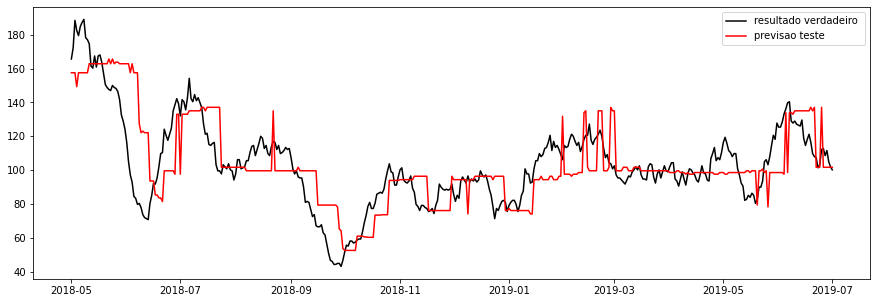

In [121]:
#treino
plot_resultados(train3_7273)

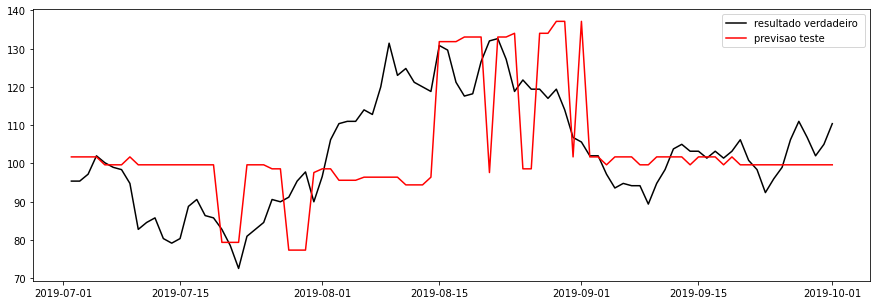

In [122]:
#Validacao
plot_resultados(val3_7273)

## Sparse data
Parece que as melhoras que obtivemos ao reduzir as dimensoes foram dominadas por outro efeito. Vamo ver se, reduzir o numero de produtos e lidar com os com muitos produtos de valores zero ajuda.

Here is what you could try doing:


Normalize your daily data. Subtract the daily series by the "daily mean" and divide by the "daily standard deviation". Run a clustering algorithm (perhaps K-Means) on your daily timeseries. Use the elbow to identify the best number of clusters.

Plot the centroids of your clusters. If you are lucky - you may be able to see distinct shapes that your forecast curve takes.

Use the Cluster Number to label each daily time series. Then use a classification model to predict the correct cluster. The features for the classification model could be "day of week", "is_holiday", "expected_average_temperature_for_the_day" etc etc.

Check if your classification model does a reasonably good job. If it does you are probably in luck. Your classification model assigns probabilities for each cluster. Combine the cluster centroids weighted by the predicted probabilities - to arrive at a predicted curve.

The predicted curve from the previous step is probably normalized - since the data-prep step (Step 3) normalized the data. You now have the task to rescale back to original data. From Step 2 - if you were able to construct a model that does a reasonable job at predicting the "mean" and "variance" for the target day - Then you could do something as simple as: Final_Curve = Normalized_Curve * sqrt(Forecasted_Variance) + Forecasted_Mean

Vamos contar o numero vendas de cada produto ao longo de todo o tempo

In [126]:
df1 = df_vendas.merge(df_prod, left_on="id_produto", right_on="produto", how="left")

In [127]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4081405 entries, 0 to 4081404
Data columns (total 18 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id_data             object
 1   id_loja             object
 2   id_unidade_negocio  object
 3   id_canal            object
 4   id_produto          object
 5   id_cupom            object
 6   id_cliente          object
 7   id_endereco_venda   object
 8   id_tipo_cliente     object
 9   qtde_venda          object
 10  valor_venda         object
 11  valor_imposto       object
 12  valor_custo         object
 13  produto             object
 14  fornecedor          object
 15  produto_nome        object
 16  categoria           object
 17  sub_categoria       object
dtypes: object(18)
memory usage: 591.6+ MB


In [129]:
dados_vazios = df1.groupby(['produto_nome', 'id_data'])['qtde_venda']\
                 .sum().reset_index()

In [130]:
dados_vazios["qtde_venda"] = df1["qtde_venda"].apply(lambda x: x.replace(',', '.')).astype('float')
dados_vazios.rename(columns={0:"venda_total"}, inplace=True)

In [131]:
freq_prod = dados_vazios.produto_nome.value_counts().reset_index()

In [132]:
freq_prod['frequencia'] = freq_prod['produto_nome']
freq_prod['produto_nome'] = freq_prod['index']
freq_prod.drop(['index'], axis=1, inplace=True)
freq_prod

,produto_nome,frequencia
0,Produto 7273,728
1,Produto 9181,727
2,Produto 5590,726
3,Produto 6770,726
4,Produto 11590,726
...,...,...
13729,Produto 5671,1
13730,Produto 6683,1
13731,Produto 13863,1
13732,Produto 10647,1


In [133]:
dados_vazios.rename(columns={0:"venda_total"}, inplace=True)

In [134]:
freq_prod[freq_prod['frequencia'] >= 365].count()

produto_nome    1430
frequencia      1430
dtype: int64

In [152]:
150/730*100

20.54794520547945

In [150]:
freq_prod[freq_prod['frequencia'] <= 150].count()

produto_nome    10316
frequencia      10316
dtype: int64

In [153]:
10316/13734*100

75.11285859909714

Podemos ver que mais de 75% dos produtos listados sao vendidos em apenas 20% dos dias. Ou seja, mais de 75% dos dados sao compostos por mais de 80% de zeros. Isso definitivamente é um problema grave para o nosso modelo de regressao. 

Vamos tentar uma solucao nao-ideal para ver o que como o modelo se comporta. Vamos manter os produtos com poucos zeros, por exemplo com 80% de valores nao nulos e remover o restante

In [162]:
#Vamos pegar os produtos que venderam em 80% dos dias
freq_venda_min = 0.8*730

produtos_ = freq_prod[freq_prod['frequencia'] >= freq_venda_min]['produto_nome']
produtos_ = pd.DataFrame(produtos_)
produtos_

,produto_nome
0,Produto 7273
1,Produto 9181
2,Produto 5590
3,Produto 6770
4,Produto 11590
...,...
622,Produto 9962
623,Produto 7218
624,Produto 1352
625,Produto 10997


In [156]:
procentagem = 627/13734*100
print('mantemos apenas {:2f}% dos produtos'.format(procentagem))

mantemos apenas 4.565312% dos produtos


In [166]:
prod_selecionados = produtos_.merge(corresp_prod)
prod_selecionados 

,produto_nome,Nproduto_nome
0,Produto 7273,84.927155
1,Produto 9181,167.399261
2,Produto 5590,270.444422
3,Produto 6770,202.664916
4,Produto 11590,164.029242
...,...,...
622,Produto 9962,12.672126
623,Produto 7218,16.809508
624,Produto 1352,14.374213
625,Produto 10997,14.564346


In [ ]:


X_train = train_encod.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_train = train_encod["target_soma_movel_15"]

X_val = cv_encod.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_val = cv_encod["target_soma_movel_15"]

X_test = test3.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_test = test3["target_soma_movel_15"]

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

### mudar os conjuntos de treino, teste o validacao com menos produtos

In [268]:
test_prod_red  = prod_selecionados.merge(test_encod.dropna()).drop(['produto_nome'], axis=1)
cv_prod_red    = prod_selecionados.merge(cv_encod).drop(['produto_nome'], axis=1)
train_prod_red = prod_selecionados.merge(train_encod).drop(['produto_nome'], axis=1)

In [269]:
test_prod_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47956 entries, 0 to 47955
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Nproduto_nome          47956 non-null  float64       
 1   id_data                47956 non-null  datetime64[ns]
 2   venda_total            47956 non-null  float64       
 3   target_soma_movel_15   47956 non-null  float64       
 4   lag_vendas_7           47956 non-null  float64       
 5   lag_vendas_14          47956 non-null  float64       
 6   lag_vendas_21          47956 non-null  float64       
 7   lag_vendas_28          47956 non-null  float64       
 8   lag_vendas_35          47956 non-null  float64       
 9   lag_vendas_42          47956 non-null  float64       
 10  lag_vendas_49          47956 non-null  float64       
 11  lag_vendas_56          47956 non-null  float64       
 12  lag_vendas_63          47956 non-null  float64       
 13  l

In [270]:
X_train_prod_red = train_prod_red.drop(["venda_total", "target_soma_movel_15", "id_data" ], axis=1)
Y_train_prod_red = train_prod_red["target_soma_movel_15"]

X_val_prod_red = cv_prod_red.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_val_prod_red = cv_prod_red["target_soma_movel_15"]

X_test_prod_red = test_prod_red.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
Y_test_prod_red = test_prod_red["target_soma_movel_15"]

## Treinar modelo em conjunto de dados reduzido

In [271]:
%%time

regrXGB = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=2,    #arvores mais rasas para evitar overvitting
                           reg_lambda= 10, #acrescentar um L2 alto para ver se conseguimos evitar overvitting
                           learning_rate=0.008)

CPU times: user 50 µs, sys: 170 µs, total: 220 µs
Wall time: 223 µs


In [272]:
regrXGB.fit(X_train_prod_red, Y_train_prod_red, 
        eval_set=[(X_train_prod_red, Y_train_prod_red), (X_val_prod_red, Y_val_prod_red)],
        verbose=100)

[16:38:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:120.50152	validation_1-rmse:124.90660
[100]	validation_0-rmse:59.22207	validation_1-rmse:63.90471
[200]	validation_0-rmse:32.23639	validation_1-rmse:37.61880
[300]	validation_0-rmse:21.25788	validation_1-rmse:26.65509
[400]	validation_0-rmse:17.38979	validation_1-rmse:22.41930
[500]	validation_0-rmse:16.16683	validation_1-rmse:20.76724
[600]	validation_0-rmse:15.74473	validation_1-rmse:20.23207
[700]	validation_0-rmse:15.51696	validation_1-rmse:20.01116
[800]	validation_0-rmse:15.35754	validation_1-rmse:19.83818
[900]	validation_0-rmse:15.25316	validation_1-rmse:19.62681
[1000]	validation_0-rmse:15.14014	validation_1-rmse:19.46228
[1100]	validation_0-rmse:15.02976	validation_1-rmse:19.32609
[1200]	validation_0-rmse:14.91643	validation_1-rmse:19.20388
[1

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [273]:
#novas estatisticas
train_prod_red['target_soma_movel_15'].describe().reset_index()

,index,target_soma_movel_15
0,count,269437.000000
1,mean,74.989057
2,std,95.861244
3,min,0.000000
4,25%,24.000000
5,50%,38.400000
6,75%,80.400000
7,max,1019.400000


In [274]:
# treino
print_metrics(X_train_prod_red, Y_train_prod_red)

SMAPE: 6.414423122996086
	Mean absolute error (MAE): 7.829887364427151
	Root Mean squared error (RMSE): 14.301967575185001
	R2 score: 0.9777409273946345


In [275]:
# validacao
print_metrics(X_val_prod_red, Y_val_prod_red)

SMAPE: 7.083971138294514
	Mean absolute error (MAE): 8.888865535599141
	Root Mean squared error (RMSE): 18.522214929916192
	R2 score: 0.9660927353447719


Aparentemente, **conseguimos remover o overfitting** com essa solucao nao-ideal

## Visualizar resultados para um produto

In [276]:
# a = float(corresp_prod[corresp_prod["produto_nome"] == "Produto 7273"]['Nproduto_nome'])

train_prod_red['previsao'] = regrXGB.predict(X_train_prod_red)
cv_prod_red['previsao']   = regrXGB.predict(X_val_prod_red)


train4_7273 = train_prod_red[train_prod_red['Nproduto_nome'] == a]
val4_7273   = cv_prod_red[cv_prod_red['Nproduto_nome'] == a]

#X_train4_7273 = train4_7273.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)
#X_val4_7273 = val4_7273.drop(["venda_total", "target_soma_movel_15", "id_data"], axis=1)


#train4_7273['previsao'] = regrXGB.predict(X_train4_7273)
#val4_7273['previsao']   = regrXGB.predict(X_val4_7273)

In [672]:
X_train_prod_red.columns

Index(['Nproduto_nome', 'lag_vendas_7', 'lag_vendas_14', 'lag_vendas_21',
       'lag_vendas_28', 'lag_vendas_35', 'lag_vendas_42', 'lag_vendas_49',
       'lag_vendas_56', 'lag_vendas_63', 'lag_vendas_70', 'lag_vendas_77',
       'lag_vendas_84', 'lag_vendas_91', 'venda_media_movel_7',
       'venda_media_movel_15', 'venda_media_movel_35', 'venda_media_movel_65',
       'venda_media_movel_95', 'venda_media_movel_120', 'Ndiadasemana',
       'Ndiadomês', 'Ndiadoano', 'Nmês', 'Nsemanadoano', 'Nestação'],
      dtype='object')

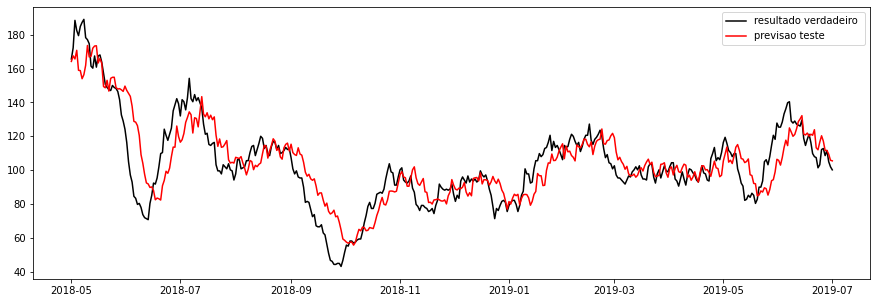

In [280]:
plot_resultados(train4_7273)

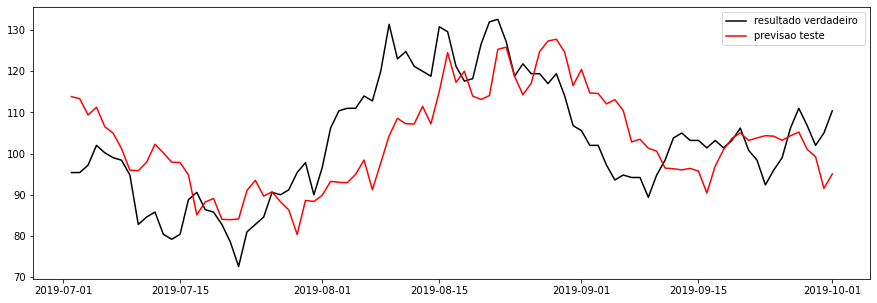

In [281]:
plot_resultados(val4_7273)

In [282]:
feature_importance= pd.DataFrame(data   = regrXGB.feature_importances_,
                 index  = regrXGB.feature_names_in_,
                 columns= ['importance'])

<Figure size 720x360 with 0 Axes>

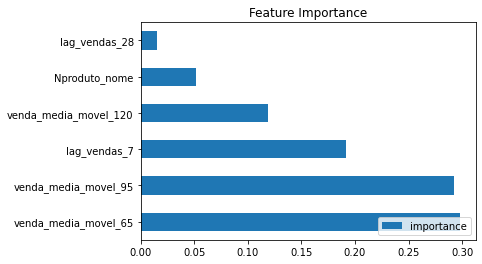

In [283]:
plt.figure(figsize=(10, 5))
fi = feature_importance.sort_values('importance', ascending=False).head(6)
fi.plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

In [284]:
#incluir lag de 1,3,4 dias

# Demanda em 30, 60, e 90 dias no futuro
* Treinar novamente em todo o conjunto de *inteiro* (treino + teste)
* Criar dataframe vazio para os valores de datas futuras
* Rodar essas datas nos codigos de criaacao de feature


## Treinar novamente em todo o conjunto de *inteiro* (treino + teste)

In [288]:
todos = pd.concat([train_prod_red, cv_prod_red, test_prod_red])

In [292]:
X_todos = todos.drop(["venda_total", "target_soma_movel_15", "id_data", "previsao"], axis=1)
Y_todos = todos["target_soma_movel_15"]

In [297]:
regrXGB = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=2000,
                           objective='reg:linear',
                           max_depth=2,    #arvores mais rasas para evitar overvitting
                           reg_lambda= 10, #acrescentar um L2 alto para ver se conseguimos evitar overvitting
                           learning_rate=0.008)

CPU times: user 90 µs, sys: 135 µs, total: 225 µs
Wall time: 243 µs


In [299]:
%%time

regrXGB.fit(X_todos, Y_todos,\
            eval_set = [(X_todos, Y_todos)], verbose=100)

[16:55:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:122.35095
[100]	validation_0-rmse:60.48137
[200]	validation_0-rmse:33.21075
[300]	validation_0-rmse:22.16156
[400]	validation_0-rmse:18.20004
[500]	validation_0-rmse:16.88959
[600]	validation_0-rmse:16.43748
[700]	validation_0-rmse:16.20722
[800]	validation_0-rmse:16.05906
[900]	validation_0-rmse:15.92900
[1000]	validation_0-rmse:15.79298
[1100]	validation_0-rmse:15.68656
[1200]	validation_0-rmse:15.57948
[1300]	validation_0-rmse:15.47672
[1400]	validation_0-rmse:15.38038
[1500]	validation_0-rmse:15.28867
[1600]	validation_0-rmse:15.20967
[1700]	validation_0-rmse:15.13472
[1800]	validation_0-rmse:15.06128
[1900]	validation_0-rmse:15.00294
[1999]	validation_0-rmse:14.93648


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [300]:
Y_todos.describe()

count    375445.000000
mean         75.397014
std          97.893245
min          -0.600000
25%          23.400000
50%          37.800000
75%          81.000000
max        1243.800000
Name: target_soma_movel_15, dtype: float64

In [301]:
print_metrics(X_todos, Y_todos)

SMAPE: 6.765590700662991
	Mean absolute error (MAE): 8.06125567115446
	Root Mean squared error (RMSE): 14.93648197154059
	R2 score: 0.9767194979604282


## Criar dataframe vazio para os valores de datas futuras

In [557]:
todos1

,Nproduto_nome,id_data,venda_total,target_soma_movel_15,lag_vendas_7,lag_vendas_14,lag_vendas_21,lag_vendas_28,lag_vendas_35,lag_vendas_42,...,venda_media_movel_95,venda_media_movel_120,Ndiadasemana,Ndiadomês,Ndiadoano,Nmês,Nsemanadoano,Nestação,previsao,futuro
0,84.927155,2018-05-01,4.8,165.6,177.0,176.4,160.8,148.8,135.6,154.2,...,10.035789,9.215,5.283817,5.422349,5.251161,5.176180,5.260727,5.344973,164.182526,True
1,84.927155,2018-05-02,7.2,172.2,181.2,171.6,166.2,156.0,138.6,150.0,...,9.884211,9.255,5.294191,5.362144,5.215054,5.176180,5.260727,5.344973,167.458389,True
2,84.927155,2018-05-03,2.4,188.4,177.6,180.0,170.4,163.2,145.2,151.2,...,9.871579,9.265,5.306433,5.358685,5.248528,5.176180,5.260727,5.344973,165.626617,True
3,84.927155,2018-05-04,23.4,182.4,181.2,186.6,175.2,174.6,152.4,144.0,...,9.840000,9.260,5.427755,5.344182,5.253055,5.176180,5.260727,5.344973,170.731430,True
4,84.927155,2018-05-05,17.4,179.4,168.6,171.0,169.8,165.6,149.4,138.0,...,10.061053,9.385,5.390384,5.356252,5.187109,5.176180,5.260727,5.344973,158.953445,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47951,57.752961,2019-12-12,0.0,0.0,0.6,7.2,7.8,5.4,7.2,5.4,...,0.448421,2.355,5.306433,5.233128,5.688305,5.413319,5.684110,5.380003,NaN,True
47952,57.752961,2019-12-13,0.0,0.0,0.0,7.2,7.8,4.2,7.8,5.4,...,0.372632,2.280,5.427755,5.223656,5.774441,5.413319,5.684110,5.380003,NaN,True
47953,57.752961,2019-12-14,0.0,0.0,0.0,7.2,7.2,6.0,5.4,4.8,...,0.334737,2.190,5.390384,5.231069,5.863786,5.413319,5.684110,5.380003,NaN,True
47954,57.752961,2019-12-15,0.0,0.0,0.0,5.4,7.2,9.0,5.4,4.8,...,0.296842,2.130,5.291385,5.243392,5.783462,5.413319,5.684110,5.380003,NaN,True


In [558]:
from datetime import timedelta

In [559]:
ultima_data_dados = todos1.id_data.max()
ultima_data_dados

Timestamp('2019-12-16 00:00:00')

In [560]:
added_date = pd.to_datetime(ultima_data_dados) + timedelta(days=90)
added_date = added_date.strftime("%Y-%m-%d")
added_date

'2020-03-15'

In [611]:
#criando o data frame com as datas do futuro 
futuro    = pd.date_range("2019-12-17", '2020-03-30')
df_futuro = pd.DataFrame({'id_data':futuro})

In [631]:
df_futuro['futuro'] = True
todos1['futuro']     = False

In [632]:
futuro_datas_e_produtos = prod_selecionados.merge(df_futuro, how="cross")

In [633]:
futuro_datas_e_produtos

,produto_nome,Nproduto_nome,id_data,futuro
0,Produto 7273,84.927155,2019-12-17,True
1,Produto 7273,84.927155,2019-12-18,True
2,Produto 7273,84.927155,2019-12-19,True
3,Produto 7273,84.927155,2019-12-20,True
4,Produto 7273,84.927155,2019-12-21,True
...,...,...,...,...
65830,Produto 1978,57.752961,2020-03-26,True
65831,Produto 1978,57.752961,2020-03-27,True
65832,Produto 1978,57.752961,2020-03-28,True
65833,Produto 1978,57.752961,2020-03-29,True


Vamos colocar esse dataframe futuro no fim do datafram existente para que possamos adicionar as features de lad corretamente

In [634]:
#todos2 = todos2.merge(corresp_prod, on='Nproduto_nome', how='left')
#todos2 = todos2.merge(corresp_ano, on='Ndiadoano', how='left')
#todos2 = todos2.merge(corresp_dmes, on='Ndiadomês', how='left')
#todos2 = todos2.merge(corresp_mes, on='Nmês', how='left')
#todos2 = todos2.merge(corresp_estacao, on='Nestação', how='left')
#todos2 = todos2.merge(corresp_sem_ano, on='Nsemanadoano', how='left')

In [635]:
todos1.columns

Index(['Nproduto_nome', 'id_data', 'venda_total', 'target_soma_movel_15',
       'futuro'],
      dtype='object')

In [636]:
#todos2.drop(['previsao', 'produto_nome', 'diadoano', 'diadomês', 'mês', 'estação',\
#       'semanadoano'], axis=1, inplace=True)

#todos2

In [637]:
prod_selecionados

,produto_nome,Nproduto_nome
0,Produto 7273,84.927155
1,Produto 9181,167.399261
2,Produto 5590,270.444422
3,Produto 6770,202.664916
4,Produto 11590,164.029242
...,...,...
622,Produto 9962,12.672126
623,Produto 7218,16.809508
624,Produto 1352,14.374213
625,Produto 10997,14.564346


In [638]:
#cortar produtos

In [639]:
dados_prod_red = prod_selecionados.merge(todos1)

In [640]:
todos_e_futuro = pd.concat([dados_prod_red[dados_prod_red['id_data'] < "2019-12-17"], futuro_datas_e_produtos])

In [641]:
todos_e_futuro.reset_index(inplace=True)

In [642]:
todos_e_futuro = todos_e_futuro.sort_values(['Nproduto_nome', 'id_data']).reset_index()

In [643]:
todos_e_futuro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446040 entries, 0 to 446039
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   level_0               446040 non-null  int64         
 1   index                 446040 non-null  int64         
 2   produto_nome          446040 non-null  object        
 3   Nproduto_nome         446040 non-null  float64       
 4   id_data               446040 non-null  datetime64[ns]
 5   venda_total           380205 non-null  float64       
 6   target_soma_movel_15  380205 non-null  float64       
 7   futuro                446040 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 24.2+ MB


In [644]:
todos_e_futuro.drop(['level_0', 'index'], axis=1, inplace=True)

In [645]:
todos_e_futuro

,produto_nome,Nproduto_nome,id_data,venda_total,target_soma_movel_15,futuro
0,Produto 9962,12.672126,2018-05-01,0.6,16.8,False
1,Produto 9962,12.672126,2018-05-02,1.8,15.0,False
2,Produto 9962,12.672126,2018-05-03,3.0,12.6,False
3,Produto 9962,12.672126,2018-05-04,1.2,12.6,False
4,Produto 9962,12.672126,2018-05-05,1.2,12.6,False
...,...,...,...,...,...,...
446035,Produto 8826,579.746130,2020-03-26,NaN,NaN,True
446036,Produto 8826,579.746130,2020-03-27,NaN,NaN,True
446037,Produto 8826,579.746130,2020-03-28,NaN,NaN,True
446038,Produto 8826,579.746130,2020-03-29,NaN,NaN,True


## Rodar essas datas nos codigos de criacao de feature

In [646]:
#Vamos adicionar nossas features de tempo de lag e de rolling mean

In [647]:
todos_e_futuro = criar_features_de_tempo(todos_e_futuro)
todos_e_futuro

,produto_nome,Nproduto_nome,id_data,venda_total,target_soma_movel_15,futuro,diadasemana,diadomês,diadoano,mês,semanadoano,estação
0,Produto 9962,12.672126,2018-05-01,0.6,16.8,False,1,1,121,5,18,1
1,Produto 9962,12.672126,2018-05-02,1.8,15.0,False,2,2,122,5,18,1
2,Produto 9962,12.672126,2018-05-03,3.0,12.6,False,3,3,123,5,18,1
3,Produto 9962,12.672126,2018-05-04,1.2,12.6,False,4,4,124,5,18,1
4,Produto 9962,12.672126,2018-05-05,1.2,12.6,False,5,5,125,5,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
446035,Produto 8826,579.746130,2020-03-26,NaN,NaN,True,3,26,86,3,13,1
446036,Produto 8826,579.746130,2020-03-27,NaN,NaN,True,4,27,87,3,13,1
446037,Produto 8826,579.746130,2020-03-28,NaN,NaN,True,5,28,88,3,13,1
446038,Produto 8826,579.746130,2020-03-29,NaN,NaN,True,6,29,89,3,13,1


In [648]:
#encoding
#todos_e_futuro = todos_e_futuro.merge(corresp_prod, on='Nproduto_nome', how='left')
todos_e_futuro = todos_e_futuro.merge(corresp_ano, on='diadoano', how='left')
todos_e_futuro = todos_e_futuro.merge(corresp_dmes, on='diadomês', how='left')
todos_e_futuro = todos_e_futuro.merge(corresp_mes, on='mês', how='left')
todos_e_futuro = todos_e_futuro.merge(corresp_estacao, on='estação', how='left')
todos_e_futuro = todos_e_futuro.merge(corresp_sem_ano, on='semanadoano', how='left')
todos_e_futuro = todos_e_futuro.merge(corresp_semana, on='diadasemana', how='left')

In [649]:
todos_e_futuro

,produto_nome,Nproduto_nome,id_data,venda_total,target_soma_movel_15,futuro,diadasemana,diadomês,diadoano,mês,semanadoano,estação,Ndiadoano,Ndiadomês,Nmês,Nestação,Nsemanadoano,Ndiadasemana
0,Produto 9962,12.672126,2018-05-01,0.6,16.8,False,1,1,121,5,18,1,5.251161,5.422349,5.176180,5.344973,5.260727,5.283817
1,Produto 9962,12.672126,2018-05-02,1.8,15.0,False,2,2,122,5,18,1,5.215054,5.362144,5.176180,5.344973,5.260727,5.294191
2,Produto 9962,12.672126,2018-05-03,3.0,12.6,False,3,3,123,5,18,1,5.248528,5.358685,5.176180,5.344973,5.260727,5.306433
3,Produto 9962,12.672126,2018-05-04,1.2,12.6,False,4,4,124,5,18,1,5.253055,5.344182,5.176180,5.344973,5.260727,5.427755
4,Produto 9962,12.672126,2018-05-05,1.2,12.6,False,5,5,125,5,18,1,5.187109,5.356252,5.176180,5.344973,5.260727,5.390384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,Produto 8826,579.746130,2020-03-26,NaN,NaN,True,3,26,86,3,13,1,5.585905,5.407677,5.559306,5.344973,5.642788,5.306433
446036,Produto 8826,579.746130,2020-03-27,NaN,NaN,True,4,27,87,3,13,1,5.612188,5.431558,5.559306,5.344973,5.642788,5.427755
446037,Produto 8826,579.746130,2020-03-28,NaN,NaN,True,5,28,88,3,13,1,5.777477,5.439773,5.559306,5.344973,5.642788,5.390384
446038,Produto 8826,579.746130,2020-03-29,NaN,NaN,True,6,29,89,3,13,1,5.749198,5.442818,5.559306,5.344973,5.642788,5.291385


In [650]:
todos_e_futuro.columns

Index(['produto_nome', 'Nproduto_nome', 'id_data', 'venda_total',
       'target_soma_movel_15', 'futuro', 'diadasemana', 'diadomês', 'diadoano',
       'mês', 'semanadoano', 'estação', 'Ndiadoano', 'Ndiadomês', 'Nmês',
       'Nestação', 'Nsemanadoano', 'Ndiadasemana'],
      dtype='object')

### Features de loop e rolling mean

In [651]:
lags = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91]

In [652]:
def features_media_mov(df, janelas):
    for window in janelas:
        df['venda_media_movel_' + str(window)] = df.groupby(["produto_nome"])['venda_total']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .mean())

In [653]:
def lag_features(df, lags):
    for lag in lags:
        df['lag_vendas_' + str(lag)] = df.groupby(["produto_nome"])['target_soma_movel_15']\
                                         .transform(lambda x: x.shift(lag))
    return df

In [654]:
lag_features

<function __main__.lag_features(df, lags)>

In [655]:
todos_e_futuro[todos_e_futuro['id_data'].between('2019-12-17', '2020-03-30')]

,produto_nome,Nproduto_nome,id_data,venda_total,target_soma_movel_15,futuro,diadasemana,diadomês,diadoano,mês,semanadoano,estação,Ndiadoano,Ndiadomês,Nmês,Nestação,Nsemanadoano,Ndiadasemana
595,Produto 9962,12.672126,2019-12-17,NaN,NaN,True,1,17,351,12,51,0,5.290849,5.242235,5.413319,5.380003,5.229537,5.283817
596,Produto 9962,12.672126,2019-12-18,NaN,NaN,True,2,18,352,12,51,0,5.330491,5.267236,5.413319,5.380003,5.229537,5.294191
597,Produto 9962,12.672126,2019-12-19,NaN,NaN,True,3,19,353,12,51,0,5.297225,5.283429,5.413319,5.380003,5.229537,5.306433
598,Produto 9962,12.672126,2019-12-20,NaN,NaN,True,4,20,354,12,51,0,5.246741,5.266890,5.413319,5.380003,5.229537,5.427755
599,Produto 9962,12.672126,2019-12-21,NaN,NaN,True,5,21,355,12,51,0,5.294883,5.297421,5.413319,5.380003,5.229537,5.390384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,Produto 8826,579.746130,2020-03-26,NaN,NaN,True,3,26,86,3,13,1,5.585905,5.407677,5.559306,5.344973,5.642788,5.306433
446036,Produto 8826,579.746130,2020-03-27,NaN,NaN,True,4,27,87,3,13,1,5.612188,5.431558,5.559306,5.344973,5.642788,5.427755
446037,Produto 8826,579.746130,2020-03-28,NaN,NaN,True,5,28,88,3,13,1,5.777477,5.439773,5.559306,5.344973,5.642788,5.390384
446038,Produto 8826,579.746130,2020-03-29,NaN,NaN,True,6,29,89,3,13,1,5.749198,5.442818,5.559306,5.344973,5.642788,5.291385


In [596]:
todos_e_futuro[todos_e_futuro['id_data'].between('2019-12-16', '2020-03-30')]

,produto_nome,Nproduto_nome,id_data,venda_total,target_soma_movel_15,futuro,diadasemana,diadomês,diadoano,mês,semanadoano,estação,Ndiadoano,Ndiadomês,Nmês,Nestação,Nsemanadoano,Ndiadasemana,lag_vendas_7
594,Produto 9962,12.672126,2019-12-16,0.6,14.4,True,0,16,350,12,51,0,5.657164,5.234113,5.413319,5.380003,5.229537,5.274769,16.8
595,Produto 9962,12.672126,2019-12-17,NaN,NaN,True,1,17,351,12,51,0,5.290849,5.242235,5.413319,5.380003,5.229537,5.283817,16.8
596,Produto 9962,12.672126,2019-12-18,NaN,NaN,True,2,18,352,12,51,0,5.330491,5.267236,5.413319,5.380003,5.229537,5.294191,17.4
597,Produto 9962,12.672126,2019-12-19,NaN,NaN,True,3,19,353,12,51,0,5.297225,5.283429,5.413319,5.380003,5.229537,5.306433,17.4
598,Produto 9962,12.672126,2019-12-20,NaN,NaN,True,4,20,354,12,51,0,5.246741,5.266890,5.413319,5.380003,5.229537,5.427755,16.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,Produto 8826,579.746130,2020-03-26,NaN,NaN,True,3,26,86,3,13,1,5.585905,5.407677,5.559306,5.344973,5.642788,5.306433,NaN
446036,Produto 8826,579.746130,2020-03-27,NaN,NaN,True,4,27,87,3,13,1,5.612188,5.431558,5.559306,5.344973,5.642788,5.427755,NaN
446037,Produto 8826,579.746130,2020-03-28,NaN,NaN,True,5,28,88,3,13,1,5.777477,5.439773,5.559306,5.344973,5.642788,5.390384,NaN
446038,Produto 8826,579.746130,2020-03-29,NaN,NaN,True,6,29,89,3,13,1,5.749198,5.442818,5.559306,5.344973,5.642788,5.291385,NaN


In [679]:
%%time
for data in df_futuro['id_data']:
    print(data)
    
    for lag in lags:
        #computar as features de lag para todos os dias
        todos_e_futuro1['lag_vendas_' + str(lag)] = todos_e_futuro1.groupby(["produto_nome"])['target_soma_movel_15']\
                                         .transform(lambda x: x.shift(lag))
        
    for window in janelas:
        #computar as features de media movel para todos os dias
        todos_e_futuro1['venda_media_movel_' + str(window)] = todos_e_futuro1.groupby(["produto_nome"])['venda_total']\
                                                 .transform(lambda x: x.shift(1)\
                                                 .rolling(window=window, min_periods=window)\
                                                 .mean())
    
    df_data = todos_e_futuro1[todos_e_futuro1['id_data']==data]

    #features
    X = df_data[['Nproduto_nome', 'lag_vendas_7', 'lag_vendas_14', 'lag_vendas_21',
       'lag_vendas_28', 'lag_vendas_35', 'lag_vendas_42', 'lag_vendas_49',
       'lag_vendas_56', 'lag_vendas_63', 'lag_vendas_70', 'lag_vendas_77',
       'lag_vendas_84', 'lag_vendas_91', 'venda_media_movel_7',
       'venda_media_movel_15', 'venda_media_movel_35', 'venda_media_movel_65',
       'venda_media_movel_95', 'venda_media_movel_120', 'Ndiadasemana',
       'Ndiadomês', 'Ndiadoano', 'Nmês', 'Nsemanadoano', 'Nestação']]
    
    
    #prever a target por dia
    pred = regrXGB.predict(X)
    
    #guardar a previsao
    df_data['target_soma_movel_15'] = pred
    

    
    # aproximar a venda total por dia pela soma movel das vendas dividido por 15 
    # esse valor sera utilizado para calcular a feature venda_media_movel_
    data_menos = pd.to_datetime(ultima_data_dados) - timedelta(days=90)
    data_menos = data_menos.strftime("%Y-%m-%d")
    
    df_data['venda_total'] = todos_e_futuro1[todos_e_futuro1['id_data']==data_menos]['target_soma_movel_15']/15
    
    
    #retirando a linha que nao tinha a target
    todos_e_futuro1 = todos_e_futuro1[todos_e_futuro1['id_data']!=data]
    
    #substituindo pela linha que tem a target
    todos_e_futuro1 = pd.concat([todos_e_futuro1, df_data]).sort_values(['Nproduto_nome', 'id_data'])\
                                                           .reset_index()\
                                                           .drop(['index'], axis=1)
    


2019-12-17 00:00:00


<timed exec>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-21 00:00:00
2019-12-22 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00
2019-12-25 00:00:00
2019-12-26 00:00:00
2019-12-27 00:00:00
2019-12-28 00:00:00
2019-12-29 00:00:00
2019-12-30 00:00:00
2019-12-31 00:00:00
2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-04 00:00:00
2020-01-05 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-11 00:00:00
2020-01-12 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-18 00:00:00
2020-01-19 00:00:00
2020-01-20 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00


# Resultado da previsao de demanda em 30, 60 e 90 dias 

In [684]:
todos_e_futuro1[['target_soma_movel_15', 'Nproduto_nome', 'produto_nome', 'id_data']]

,target_soma_movel_15,Nproduto_nome,produto_nome,id_data
0,16.800000,12.672126,Produto 9962,2018-05-01
1,15.000000,12.672126,Produto 9962,2018-05-02
2,12.600000,12.672126,Produto 9962,2018-05-03
3,12.600000,12.672126,Produto 9962,2018-05-04
4,12.600000,12.672126,Produto 9962,2018-05-05
...,...,...,...,...
446035,705.017761,579.746130,Produto 8826,2020-03-26
446036,705.017761,579.746130,Produto 8826,2020-03-27
446037,705.017761,579.746130,Produto 8826,2020-03-28
446038,705.017761,579.746130,Produto 8826,2020-03-29


A target é soma dos proximos 15 dias. Portanto, para prever a venda total em 30, 60 e 90 dias, podemos pegar:
### Venda total em 60 dias:
vamos pegar a target_soma_movel_15 das datas:
* 2020-01-01
* 2020-01-16

### Venda total em 60 dias:
vamos pegar a target_soma_movel_15 das datas:
* 2020-01-01
* 2020-01-16
* 2020-01-31
* 2020-02-15

### Venda total em 90 dias:
vamos pegar a target_soma_movel_15 das datas:
* 2020-01-01
* 2020-01-16
* 2020-01-31
* 2020-02-15
* 2020-03-01
* 2020-03-16

In [697]:
primeiros_15_dias_por_produto = todos_e_futuro1[(todos_e_futuro1['id_data'] == '2020-01-01')]
primeiros_15_dias_por_produto = primeiros_15_dias_por_produto[['produto_nome', 'target_soma_movel_15']]

segundos_15_dias_por_produto = todos_e_futuro1[(todos_e_futuro1['id_data'] == '2020-01-16')]
segundos_15_dias_por_produto = segundos_15_dias_por_produto[['produto_nome', 'target_soma_movel_15']]

terceiros_15_dias_por_produto = todos_e_futuro1[(todos_e_futuro1['id_data'] == '2020-01-31')]
terceiros_15_dias_por_produto = terceiros_15_dias_por_produto[['produto_nome', 'target_soma_movel_15']]

quartos_15_dias_por_produto = todos_e_futuro1[(todos_e_futuro1['id_data'] == '2020-02-15')]
quartos_15_dias_por_produto = quartos_15_dias_por_produto[['produto_nome', 'target_soma_movel_15']]

quintos_15_dias_por_produto = todos_e_futuro1[(todos_e_futuro1['id_data'] == '2020-03-01')]
quintos_15_dias_por_produto = quintos_15_dias_por_produto[['produto_nome', 'target_soma_movel_15']]

sextos_15_dias_por_produto = todos_e_futuro1[(todos_e_futuro1['id_data'] == '2020-03-16')]
sextos_15_dias_por_produto = sextos_15_dias_por_produto[['produto_nome', 'target_soma_movel_15']]

### Venda total por produto em 30 dias:


In [702]:
venda_total_30_dias = pd.DataFrame()
venda_total_30_dias['produto_nome'] = primeiros_15_dias_por_produto['produto_nome']

In [713]:
primeiros_15_dias_por_produto['target_soma_movel_15']

610        27.815073
1310       27.815073
2010       25.616892
2710       28.401173
3410       28.777702
             ...    
443150    620.711609
443850    634.182129
444550    989.836975
445250    654.309204
445950    665.330017
Name: target_soma_movel_15, Length: 627, dtype: float64

In [718]:
segundos_15_dias_por_produto['target_soma_movel_15'] + primeiros_15_dias_por_produto['target_soma_movel_15']

610      NaN
625      NaN
1310     NaN
1325     NaN
2010     NaN
          ..
444565   NaN
445250   NaN
445265   NaN
445950   NaN
445965   NaN
Name: target_soma_movel_15, Length: 1254, dtype: float64

In [724]:
venda_total_30_dias['segundos_15_dias_por_produto'] = segundos_15_dias_por_produto['target_soma_movel_15']
venda_total_30_dias

,produto_nome,numero_de_vendas,primeiros_15_dias_por_produto,segundos_15_dias_por_produto
610,Produto 9962,27.815073,27.815073,NaN
1310,Produto 11107,27.815073,27.815073,NaN
2010,Produto 5313,25.616892,25.616892,NaN
2710,Produto 9130,28.401173,28.401173,NaN
3410,Produto 12776,28.777702,28.777702,NaN
...,...,...,...,...
443150,Produto 7178,620.711609,620.711609,NaN
443850,Produto 6385,634.182129,634.182129,NaN
444550,Produto 12150,989.836975,989.836975,NaN
445250,Produto 3415,654.309204,654.309204,NaN


In [733]:
venda_total_30_dias = pd.DataFrame()
venda_total_30_dias['produto_nome'] = primeiros_15_dias_por_produto.reset_index()['produto_nome']
venda_total_30_dias['numero_de_vendas'] = primeiros_15_dias_por_produto.reset_index()['target_soma_movel_15']\
                                            .add(segundos_15_dias_por_produto.reset_index()['target_soma_movel_15'], fill_value=0)
venda_total_30_dias

,produto_nome,numero_de_vendas
0,Produto 9962,59.503574
1,Produto 11107,59.735405
2,Produto 5313,55.744776
3,Produto 9130,60.169577
4,Produto 12776,61.195797
...,...,...
622,Produto 7178,1305.592468
623,Produto 6385,1316.776367
624,Produto 12150,1965.045288
625,Produto 3415,1347.166992


### Venda total por produto em 60 dias:

In [734]:
venda_total_60_dias = pd.DataFrame()
venda_total_60_dias['produto_nome'] = primeiros_15_dias_por_produto.reset_index()['produto_nome']
venda_total_60_dias['numero_de_vendas'] = venda_total_30_dias.reset_index()['numero_de_vendas'].add\
                                         (terceiros_15_dias_por_produto.reset_index()['target_soma_movel_15'], fill_value=0)

venda_total_60_dias['numero_de_vendas'] = venda_total_60_dias.reset_index()['numero_de_vendas'].add\
                                         (quartos_15_dias_por_produto.reset_index()['target_soma_movel_15'], fill_value=0)

venda_total_60_dias

,produto_nome,numero_de_vendas
0,Produto 9962,132.926109
1,Produto 11107,134.064941
2,Produto 5313,126.748560
3,Produto 9130,135.563581
4,Produto 12776,135.724461
...,...,...
622,Produto 7178,2702.124695
623,Produto 6385,2717.925537
624,Produto 12150,3937.799561
625,Produto 3415,2750.361450


In [736]:
venda_total_90_dias = pd.DataFrame()
venda_total_90_dias['produto_nome'] = primeiros_15_dias_por_produto.reset_index()['produto_nome']
venda_total_90_dias['numero_de_vendas'] = venda_total_60_dias.reset_index()['numero_de_vendas'].add\
                                         (quintos_15_dias_por_produto.reset_index()['target_soma_movel_15'], fill_value=0)

venda_total_90_dias['numero_de_vendas'] = venda_total_60_dias.reset_index()['numero_de_vendas'].add\
                                         (sextos_15_dias_por_produto.reset_index()['target_soma_movel_15'], fill_value=0)

venda_total_90_dias

,produto_nome,numero_de_vendas
0,Produto 9962,177.898506
1,Produto 11107,180.078049
2,Produto 5313,171.720957
3,Produto 9130,182.989183
4,Produto 12776,180.656136
...,...,...
622,Produto 7178,3402.720520
623,Produto 6385,3418.521362
624,Produto 12150,4926.021118
625,Produto 3415,3450.822388


Assim conseguimos prever as demandas em 30, 60 e 90 para os 600 produtos mais vendidos!